# Deep Agents: Building Complex Agents for Long-Horizon Tasks

In this notebook, we'll explore **Deep Agents** - a new approach to building AI agents that can handle complex, multi-step tasks over extended periods. We'll implement all four key elements of Deep Agents while building on our Personal Wellness Assistant use case.

**Learning Objectives:**
- Understand the four key elements of Deep Agents: Planning, Context Management, Subagent Spawning, and Long-term Memory
- Implement each element progressively using the `deepagents` package
- Learn to use Skills for progressive capability disclosure
- Use the `deepagents-cli` for interactive agent sessions

## Table of Contents:

- **Breakout Room #1:** Deep Agent Foundations
  - Task 1: Dependencies & Setup
  - Task 2: Understanding Deep Agents
  - Task 3: Planning with Todo Lists
  - Task 4: Context Management with File Systems
  - Task 5: Basic Deep Agent
  - Question #1 & Question #2
  - Activity #1: Build a Research Agent

- **Breakout Room #2:** Advanced Features & Integration
  - Task 6: Subagent Spawning
  - Task 7: Long-term Memory Integration
  - Task 8: Skills - On-Demand Capabilities
  - Task 9: Using deepagents-cli
  - Task 10: Building a Complete Deep Agent System
  - Question #3 & Question #4
  - Activity #2: Build a Wellness Coach Agent

---
# 🤝 Breakout Room #1
## Deep Agent Foundations

## Task 1: Dependencies & Setup

Before we begin, make sure you have:

1. **API Keys** for:
   - Anthropic (default for Deep Agents) or OpenAI
   - LangSmith (optional, for tracing)
   - Tavily (optional, for web search)

2. **Dependencies installed** via `uv sync`

3. **For the CLI** (Task 9): `uv pip install deepagents-cli`

### Environment Setup

You can either:
- Create a `.env` file with your API keys (recommended):
  ```
  ANTHROPIC_API_KEY=your_key_here
  OPENAI_API_KEY=your_key_here
  LANGCHAIN_API_KEY=your_key_here
  ```
- Or enter them interactively when prompted

In [1]:
# Core imports
import os
import getpass
from uuid import uuid4
from typing import Annotated, TypedDict, Literal

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

# Load environment variables from .env file
from dotenv import load_dotenv
load_dotenv()

def get_api_key(env_var: str, prompt: str) -> str:
    """Get API key from environment or prompt user."""
    value = os.environ.get(env_var, "")
    if not value:
        value = getpass.getpass(prompt)
        if value:
            os.environ[env_var] = value
    return value

In [2]:
# Set Anthropic API Key (default for Deep Agents)
anthropic_key = get_api_key("ANTHROPIC_API_KEY", "Anthropic API Key: ")
if anthropic_key:
    print("Anthropic API key set")
else:
    print("Warning: No Anthropic API key configured")

Anthropic API key set


In [3]:
# Optional: OpenAI for alternative models and subagents
openai_key = get_api_key("OPENAI_API_KEY", "OpenAI API Key (press Enter to skip): ")
if openai_key:
    print("OpenAI API key set")
else:
    print("OpenAI API key not configured (optional)")

OpenAI API key set


In [4]:
# Optional: LangSmith for tracing
langsmith_key = get_api_key("LANGCHAIN_API_KEY", "LangSmith API Key (press Enter to skip): ")

if langsmith_key:
    os.environ["LANGCHAIN_TRACING_V2"] = "true"
    os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - Deep Agents - {uuid4().hex[0:8]}"
    print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")
else:
    os.environ["LANGCHAIN_TRACING_V2"] = "false"
    print("LangSmith tracing disabled")

LangSmith tracing enabled. Project: AIE9 - Deep Agents - e5769dcf


In [5]:
# Verify deepagents installation
from deepagents import create_deep_agent
print("deepagents package imported successfully!")

# Test with a simple agent
test_agent = create_deep_agent()
result = test_agent.invoke({
    "messages": [{"role": "user", "content": "Say 'Deep Agents ready!' in exactly those words."}]
})
print(result["messages"][-1].content)

deepagents package imported successfully!
Deep Agents ready!


## Task 2: Understanding Deep Agents

**Deep Agents** represent a shift from simple tool-calling loops to sophisticated agents that can handle complex, long-horizon tasks. They address four key challenges:

### The Four Key Elements

| Element | Challenge Addressed | Implementation |
|---------|---------------------|----------------|
| **Planning** | "What should I do?" | Todo lists that persist task state |
| **Context Management** | "What do I know?" | File systems for storing/retrieving info |
| **Subagent Spawning** | "Who can help?" | Task tool for delegating to specialists |
| **Long-term Memory** | "What did I learn?" | LangGraph Store for cross-session memory |

### Deep Agents vs Traditional Agents

```
Traditional Agent Loop:
┌─────────────────────────────────────┐
│  User Query                         │
│       ↓                             │
│  Think → Act → Observe → Repeat     │
│       ↓                             │
│  Response                           │
└─────────────────────────────────────┘
Problems: Context bloat, no delegation,
          loses track of complex tasks

Deep Agent Architecture:
┌─────────────────────────────────────────────────────────┐
│                    Deep Agent                           │
├─────────────────────────────────────────────────────────┤
│  ┌──────────────┐  ┌──────────────┐  ┌──────────────┐   │
│  │   PLANNING   │  │   CONTEXT    │  │   MEMORY     │   │
│  │              │  │  MANAGEMENT  │  │              │   │
│  │ write_todos  │  │              │  │   Store      │   │
│  │ update_todo  │  │  read_file   │  │  namespace   │   │
│  │ list_todos   │  │  write_file  │  │  get/put     │   │
│  │              │  │  edit_file   │  │              │   │
│  └──────────────┘  │  ls          │  └──────────────┘   │
│                    └──────────────┘                     │
│  ┌──────────────────────────────────────────────────┐   │
│  │              SUBAGENT SPAWNING                   │   │
│  │                                                  │   │
│  │  task(prompt, tools, model, system_prompt)       │   │
│  │       ↓              ↓              ↓            │   │
│  │  ┌────────┐    ┌────────┐    ┌────────┐          │   │
│  │  │Research│    │Writing │    │Analysis│          │   │
│  │  │Subagent│    │Subagent│    │Subagent│          │   │
│  │  └────────┘    └────────┘    └────────┘          │   │
│  └──────────────────────────────────────────────────┘   │
└─────────────────────────────────────────────────────────┘
```

### When to Use Deep Agents

| Use Case | Traditional Agent | Deep Agent |
|----------|-------------------|------------|
| Simple Q&A | ✅ | Overkill |
| Single-step tool use | ✅ | Overkill |
| Multi-step research | ⚠️ May lose track | ✅ |
| Complex projects | ❌ Context overflow | ✅ |
| Parallel task execution | ❌ | ✅ |
| Long-running sessions | ❌ | ✅ |

### Key Insight: "Planning is Context Engineering"

Deep Agents treat planning not as a separate phase, but as **context engineering**:
- Todo lists aren't just task trackers—they're **persistent context** about what to do
- File systems aren't just storage—they're **extended memory** beyond the context window
- Subagents aren't just helpers—they're **context isolation** to prevent bloat

## Task 3: Planning with Todo Lists

The first key element of Deep Agents is **Planning**. Instead of trying to hold all task state in the conversation, Deep Agents use structured todo lists.

### Why Todo Lists?

1. **Persistence**: Tasks survive across conversation turns
2. **Visibility**: Both agent and user can see progress
3. **Structure**: Clear tracking of what's done vs pending
4. **Recovery**: Agent can resume from where it left off

### Todo List Tools

| Tool | Purpose |
|------|----------|
| `write_todos` | Create a structured task list |
| `update_todo` | Mark tasks as complete/in-progress |
| `list_todos` | View current task state |

In [6]:
from langchain_core.tools import tool
from typing import List, Optional
from enum import Enum, auto
import json

# =============================================================================
# Phase Enum - Defines the execution order for todos
# =============================================================================
class Phase(str, Enum):
    """
    Phases for todo execution, in order:
    1. ASSESSMENT - Reading the user question and understanding the request
    2. DISCOVERY - Discovering what tools or resources can help
    3. PLANNING - Planning for the run
    4. EXECUTION - Actually doing the work
    """
    ASSESSMENT = "assessment"
    DISCOVERY = "discovery"
    PLANNING = "planning"
    EXECUTION = "execution"
    
    @classmethod
    def get_order(cls) -> List["Phase"]:
        """Returns phases in execution order."""
        return [cls.ASSESSMENT, cls.DISCOVERY, cls.PLANNING, cls.EXECUTION]
    
    @classmethod
    def get_phase_index(cls, phase: "Phase") -> int:
        """Returns the index of a phase in execution order (0-3)."""
        return cls.get_order().index(phase)
    
    @classmethod
    def can_execute(cls, phase: "Phase", completed_phases: set) -> bool:
        """
        Check if a phase can execute based on completed phases.
        A phase can execute if all previous phases are completed.
        """
        phase_order = cls.get_order()
        phase_idx = phase_order.index(phase)
        
        # All phases before this one must be completed
        for i in range(phase_idx):
            if phase_order[i] not in completed_phases:
                return False
        return True


# Simple in-memory todo storage for demonstration
# In production, Deep Agents use persistent storage
TODO_STORE = {}

@tool
def write_todos(todos: List[dict]) -> str:
    """Create a list of todos for tracking task progress.
    
    Args:
        todos: List of todo items, each with:
            - 'title': Task title (required)
            - 'description': Task description (optional)
            - 'phase': One of 'assessment', 'discovery', 'planning', 'execution' (default: 'discovery')
            - 'depends_on': ID of todo this depends on (optional)
    
    Phases execute in order:
        1. assessment - Understanding the user's request
        2. discovery - Finding tools and resources
        3. planning - Planning the approach
        4. execution - Doing the work
    
    Returns:
        Confirmation message with todo IDs
    """
    created = []
    for i, todo in enumerate(todos):
        todo_id = f"todo_{len(TODO_STORE) + i + 1}"
        
        # Validate and set phase
        phase_str = todo.get("phase", "discovery").lower()
        try:
            phase = Phase(phase_str)
        except ValueError:
            phase = Phase.DISCOVERY  # Default to discovery if invalid
            
        TODO_STORE[todo_id] = {
            "id": todo_id,
            "title": todo.get("title", "Untitled"),
            "description": todo.get("description", ""),
            "phase": phase.value,
            "depends_on": todo.get("depends_on", None),
            "status": "pending"
        }
        created.append(todo_id)
    return f"Created {len(created)} todos: {', '.join(created)}"

@tool
def update_todo(todo_id: str, status: Literal["pending", "in_progress", "completed"]) -> str:
    """Update the status of a todo item.
    
    Args:
        todo_id: The ID of the todo to update
        status: New status (pending, in_progress, completed)
    
    Returns:
        Confirmation message
    """
    if todo_id not in TODO_STORE:
        return f"Todo {todo_id} not found"
    TODO_STORE[todo_id]["status"] = status
    return f"Updated {todo_id} to {status}"

@tool
def list_todos() -> str:
    """List all todos with their current status, grouped by phase.
    
    Returns:
        Formatted list of all todos organized by phase
    """
    if not TODO_STORE:
        return "No todos found"
    
    status_emoji = {"pending": "⬜", "in_progress": "🔄", "completed": "✅"}
    phase_emoji = {
        Phase.ASSESSMENT.value: "🔍",
        Phase.DISCOVERY.value: "🔎", 
        Phase.PLANNING.value: "📋",
        Phase.EXECUTION.value: "⚡"
    }
    
    # Group todos by phase
    todos_by_phase = {phase.value: [] for phase in Phase.get_order()}
    for todo_id, todo in TODO_STORE.items():
        phase = todo.get("phase", Phase.DISCOVERY.value)
        if phase in todos_by_phase:
            todos_by_phase[phase].append((todo_id, todo))
    
    result = []
    for phase in Phase.get_order():
        phase_todos = todos_by_phase[phase.value]
        if phase_todos:
            result.append(f"\n{phase_emoji.get(phase.value, '')} {phase.value.upper()}")
            result.append("-" * 40)
            for todo_id, todo in phase_todos:
                emoji = status_emoji.get(todo["status"], "❓")
                depends = f" (depends on: {todo['depends_on']})" if todo.get("depends_on") else ""
                result.append(f"  {emoji} [{todo_id}] {todo['title']} ({todo['status']}){depends}")
    
    return "\n".join(result)

@tool
def get_next_todos() -> str:
    """Get the next todos that can be executed based on phase order and dependencies.
    
    Phases execute in order: assessment → discovery → planning → execution
    A todo can only start if:
    1. All todos in previous phases are completed
    2. Its dependencies (if any) are completed
    
    Returns:
        List of todo IDs that are ready to execute
    """
    if not TODO_STORE:
        return "No todos found"
    
    # Get completed phases
    completed_phases = set()
    for phase in Phase.get_order():
        phase_todos = [t for t in TODO_STORE.values() if t["phase"] == phase.value]
        if phase_todos and all(t["status"] == "completed" for t in phase_todos):
            completed_phases.add(phase)
    
    # Find todos ready to execute
    ready_todos = []
    for todo_id, todo in TODO_STORE.items():
        if todo["status"] == "completed":
            continue
            
        phase = Phase(todo["phase"])
        
        # Check if phase can execute
        if not Phase.can_execute(phase, completed_phases):
            continue
            
        # Check dependencies
        depends_on = todo.get("depends_on")
        if depends_on:
            if depends_on not in TODO_STORE:
                continue
            if TODO_STORE[depends_on]["status"] != "completed":
                continue
        
        ready_todos.append(todo_id)
    
    if not ready_todos:
        # Check if all done
        if all(t["status"] == "completed" for t in TODO_STORE.values()):
            return "All todos completed! ✅"
        return "No todos ready - waiting on dependencies or previous phases"
    
    return f"Ready to execute: {', '.join(ready_todos)}"

print("Todo tools defined!")
print(f"Phases: {' → '.join([p.value for p in Phase.get_order()])}")

Todo tools defined!
Phases: assessment → discovery → planning → execution


In [7]:
# Test the todo tools with dynamic generation from user question
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate

TODO_STORE.clear()  # Reset for demo

# User question for testing
user_question = "I'm 35 and want to retire by 60, how much do I need to save each year?"

# Create a prompt to generate a structured todo list
todo_generation_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a Life Coach planning assistant. Given a user's question, create a structured todo list 
to help answer their question thoroughly.

Generate todos across the 4 phases in order:
1. ASSESSMENT - Understanding the user's situation and question
2. DISCOVERY - Finding relevant tools, resources, or information needed  
3. PLANNING - Creating a plan to address the question
4. EXECUTION - Actually doing the work to answer/help

Return a JSON array of todo objects. Each todo should have:
- "title": A clear, actionable title
- "description": Brief description of what this step involves
- "phase": One of "assessment", "discovery", "planning", "execution"
- "depends_on": Optional - the todo_id this depends on (use format "todo_1", "todo_2", etc.)

Generate 6-10 todos that thoroughly address the user's question.
Return ONLY valid JSON, no markdown or explanation."""),
    ("human", "{question}")
])

# Generate todos using LLM
todo_llm = init_chat_model("openai:gpt-4o-mini")
todo_chain = todo_generation_prompt | todo_llm

print(f"User Question: {user_question}")
print("=" * 60)
print("Generating todo list...")

response = todo_chain.invoke({"question": user_question})

# Parse the response and create todos
import json
try:
    todos = json.loads(response.content)
    result = write_todos.invoke({"todos": todos})
    print(f"\n{result}")
    print("\n" + "=" * 60)
    print("Generated Todo List:")
    print("=" * 60)
    print(list_todos.invoke({}))
    print("\n" + "=" * 60)
    print("Next todos ready to execute:")
    print(get_next_todos.invoke({}))
except json.JSONDecodeError as e:
    print(f"Error parsing LLM response: {e}")
    print(f"Raw response: {response.content}")

User Question: I'm 35 and want to retire by 60, how much do I need to save each year?
Generating todo list...

Created 9 todos: todo_1, todo_3, todo_5, todo_7, todo_9, todo_11, todo_13, todo_15, todo_17

Generated Todo List:

🔍 ASSESSMENT
----------------------------------------
  ⬜ [todo_1] Gather Personal Financial Information (pending)
  ⬜ [todo_3] Understand Retirement Goals (pending)

🔎 DISCOVERY
----------------------------------------
  ⬜ [todo_5] Research Retirement Savings Calculators (pending)
  ⬜ [todo_7] Identify Investment Options (pending)

📋 PLANNING
----------------------------------------
  ⬜ [todo_9] Set a Retirement Savings Goal (pending)
  ⬜ [todo_11] Create a Yearly Savings Plan (pending)
  ⬜ [todo_13] Develop a Budget for Savings (pending)

⚡ EXECUTION
----------------------------------------
  ⬜ [todo_15] Implement Your Savings Plan (pending)
  ⬜ [todo_17] Track Your Progress (pending)

Next todos ready to execute:
Ready to execute: todo_1, todo_3


In [8]:
# Simulate progress
# TODO: DJY -  - actually track progress
update_todo.invoke({"todo_id": "todo_1", "status": "completed", "phase": "assessment", "depends_on": None})
update_todo.invoke({"todo_id": "todo_2", "status": "in_progress", "phase": "discovery", "depends_on": "assessment"})

print("After updates:")
print(list_todos.invoke({}))

After updates:

🔍 ASSESSMENT
----------------------------------------
  ✅ [todo_1] Gather Personal Financial Information (completed)
  ⬜ [todo_3] Understand Retirement Goals (pending)

🔎 DISCOVERY
----------------------------------------
  ⬜ [todo_5] Research Retirement Savings Calculators (pending)
  ⬜ [todo_7] Identify Investment Options (pending)

📋 PLANNING
----------------------------------------
  ⬜ [todo_9] Set a Retirement Savings Goal (pending)
  ⬜ [todo_11] Create a Yearly Savings Plan (pending)
  ⬜ [todo_13] Develop a Budget for Savings (pending)

⚡ EXECUTION
----------------------------------------
  ⬜ [todo_15] Implement Your Savings Plan (pending)
  ⬜ [todo_17] Track Your Progress (pending)


## Task 4: Context Management with File Systems

The second key element is **Context Management**. Deep Agents use file systems to:

1. **Offload large content** - Store research, documents, and results to disk
2. **Persist across sessions** - Files survive beyond conversation context
3. **Share between subagents** - Subagents can read/write shared files
4. **Prevent context overflow** - Large tool results automatically saved to disk

### Automatic Context Management

Deep Agents automatically handle context limits:
- **Large result offloading**: Tool results >20k tokens → saved to disk
- **Proactive offloading**: At 85% context capacity → agent saves state to disk
- **Summarization**: Long conversations get summarized while preserving intent

### File System Tools

| Tool | Purpose |
|------|----------|
| `ls` | List directory contents |
| `read_file` | Read file contents |
| `write_file` | Create/overwrite files |
| `edit_file` | Make targeted edits |

In [ ]:
import os
import json
import uuid
from pathlib import Path
from datetime import datetime
from langgraph.store.memory import InMemoryStore

# =============================================================================
# Short-Term Memory: Session Conversation Store
# =============================================================================
# Each conversation gets a unique thread_id for short-term memory
# This memory stores conversation history for the current session

thread_id = uuid.uuid4()
config = {"configurable": {"thread_id": thread_id}}
user_id = "user_alex"

# Create short-term memory store for conversation history
short_term_store = InMemoryStore()

print(f"Session initialized:")
print(f"  thread_id: {thread_id}")
print(f"  user_id: {user_id}")
print(f"  short_term_store: InMemoryStore ready")

# =============================================================================
# Context Management Directory Structure
# =============================================================================
# Each user gets their own context directory with 5 subdirectories:
#   user_profile/ - Long-term user information
#   assessments/  - Completed assessments and reflections
#   plans/        - Active and archived action plans
#   progress/     - Weekly check-ins and milestones
#   resources/    - Curated articles, exercises, worksheets

WORKSPACE = Path("advanced_build")
WORKSPACE.mkdir(exist_ok=True)

# =============================================================================
# Context Directory Structure (maps to memory namespaces)
# =============================================================================
# User-specific namespaces:
#   (user_id, "profile")     → profile/      - Demographics, values, life situation
#   (user_id, "goals")       → goals/        - Short, medium, long-term goals
#   (user_id, "progress")    → progress/     - Milestones achieved, setbacks overcome
#   (user_id, "preferences") → preferences/  - Communication style, coaching approach
#
# Additional user context:
#   assessments/ - Completed assessments and reflections
#   plans/       - Active and archived action plans
#   resources/   - Curated articles, exercises, worksheets
#
# Global namespace (shared across users):
#   ("coaching", "patterns") → WORKSPACE/coaching/patterns/ - Learned patterns (anonymized)

CONTEXT_DIRS = {
    # Core namespaces (matching memory namespace pattern)
    "profile": "Demographics, values, life situation",
    "goals": "Short, medium, long-term goals",
    "progress": "Milestones achieved, setbacks overcome",
    "preferences": "Communication style, coaching approach",
    # Additional context directories
    "assessments": "Completed assessments and reflections",
    "plans": "Active and archived action plans",
    "resources": "Curated articles, exercises, worksheets"
}

# Global directories (not user-specific)
GLOBAL_DIRS = {
    "coaching/patterns": "Learned patterns across users (anonymized)"
}

def create_user_context(user_id: str) -> Path:
    """
    Create the context management directory structure for a user.
    
    Creates directories matching these memory namespaces:
        (user_id, "profile")     → profile/
        (user_id, "goals")       → goals/
        (user_id, "progress")    → progress/
        (user_id, "preferences") → preferences/
    
    Plus additional context directories:
        assessments/, plans/, resources/
    
    Args:
        user_id: Unique identifier for the user (e.g., 'user_alex')
    
    Returns:
        Path to the user's root directory
    """
    user_dir = WORKSPACE / user_id
    user_dir.mkdir(exist_ok=True)
    
    # Create each context subdirectory
    for dir_name, description in CONTEXT_DIRS.items():
        subdir = user_dir / dir_name
        subdir.mkdir(exist_ok=True)
        
        # Create a README in each directory explaining its purpose
        readme_path = subdir / "README.md"
        if not readme_path.exists():
            readme_path.write_text(f"# {dir_name.replace('_', ' ').title()}\n\n{description}\n")
    
    return user_dir


def create_global_context() -> None:
    """
    Create global context directories shared across all users.
    
    Creates:
        ("coaching", "patterns") → WORKSPACE/coaching/patterns/
    """
    for dir_path, description in GLOBAL_DIRS.items():
        full_path = WORKSPACE / dir_path
        full_path.mkdir(parents=True, exist_ok=True)
        
        readme_path = full_path / "README.md"
        if not readme_path.exists():
            readme_path.write_text(f"# {dir_path.split('/')[-1].replace('_', ' ').title()}\n\n{description}\n")


def get_global_context_path(namespace: str, subnamespace: str) -> Path:
    """
    Get the path to a global context directory.
    
    Args:
        namespace: Top-level namespace (e.g., 'coaching')
        subnamespace: Sub-namespace (e.g., 'patterns')
    
    Returns:
        Path to the global context directory
    """
    return WORKSPACE / namespace / subnamespace

def get_user_context_path(user_id: str, context_type: str) -> Path:
    """
    Get the path to a specific context directory for a user.
    
    Args:
        user_id: User identifier
        context_type: One of 'user_profile', 'assessments', 'plans', 'progress', 'resources'
    
    Returns:
        Path to the context directory
    """
    if context_type not in CONTEXT_DIRS:
        raise ValueError(f"Invalid context type: {context_type}. Must be one of: {list(CONTEXT_DIRS.keys())}")
    return WORKSPACE / user_id / context_type

def list_user_context(user_id: str) -> dict:
    """
    List all files in each context directory for a user.
    
    Args:
        user_id: User identifier
    
    Returns:
        Dictionary with context types as keys and list of files as values
    """
    user_dir = WORKSPACE / user_id
    if not user_dir.exists():
        return {"error": f"User directory not found: {user_id}"}
    
    context_files = {}
    for dir_name in CONTEXT_DIRS.keys():
        subdir = user_dir / dir_name
        if subdir.exists():
            files = [f.name for f in subdir.iterdir() if f.is_file() and f.name != "README.md"]
            context_files[dir_name] = files
    
    return context_files

@tool
def ls(path: str = ".") -> str:
    """List contents of a directory.
    
    Args:
        path: Directory path to list (default: current directory)
    
    Returns:
        List of files and directories
    """
    target = WORKSPACE / path
    if not target.exists():
        return f"Directory not found: {path}"
    
    items = []
    for item in sorted(target.iterdir()):
        prefix = "[DIR]" if item.is_dir() else "[FILE]"
        size = f" ({item.stat().st_size} bytes)" if item.is_file() else ""
        items.append(f"{prefix} {item.name}{size}")
    
    return "\n".join(items) if items else "(empty directory)"

@tool
def read_file(path: str) -> str:
    """Read contents of a file.
    
    Args:
        path: Path to the file to read
    
    Returns:
        File contents
    """
    target = WORKSPACE / path
    if not target.exists():
        return f"File not found: {path}"
    return target.read_text()

@tool
def write_file(path: str, content: str) -> str:
    """Write content to a file (creates or overwrites).
    
    Args:
        path: Path to the file to write
        content: Content to write to the file
    
    Returns:
        Confirmation message
    """
    target = WORKSPACE / path
    target.parent.mkdir(parents=True, exist_ok=True)
    target.write_text(content)
    return f"Wrote {len(content)} characters to {path}"

@tool
def edit_file(path: str, old_text: str, new_text: str) -> str:
    """Edit a file by replacing text.
    
    Args:
        path: Path to the file to edit
        old_text: Text to find and replace
        new_text: Replacement text
    
    Returns:
        Confirmation message
    """
    target = WORKSPACE / path
    if not target.exists():
        return f"File not found: {path}"
    
    content = target.read_text()
    if old_text not in content:
        return f"Text not found in {path}"
    
    new_content = content.replace(old_text, new_text, 1)
    target.write_text(new_content)
    return f"Updated {path}"

print("File system tools defined!")
print(f"Workspace: {WORKSPACE.absolute()}")

File system tools defined!
Workspace: /Users/dereky/old/personal/code/ai-makerspace-code/AIE9/07_Deep_Agents/advanced_build


In [10]:
# Test the file system tools
print("Current workspace contents:")
print(ls.invoke({"path": "."}))

Current workspace contents:
[FILE] 90_day_financial_plan.txt (2700 bytes)
[FILE] alex_career_plan_90days.md (13805 bytes)
[FILE] alex_financial_plan_90days.md (5674 bytes)
[FILE] alex_fitness_plan_90days.md (3946 bytes)
[FILE] alex_master_90day_action_plan.md (10220 bytes)
[FILE] alex_relationships_plan_90days.md (9146 bytes)
[DIR] coaching
[DIR] user_alex


In [11]:
# Create a research notes file
# TODO: DJY - : need to actually have sub-agents do research and write to files
# notes = """# Sleep Research Notes

# ## Key Findings
# - Adults need 7-9 hours of sleep
# - Consistent sleep schedule is important
# - Blue light affects melatonin production

# ## TODO
# - [ ] Review individual user needs
# - [ ] Create personalized recommendations
# """

# result = write_file.invoke({"path": "research/sleep_notes.md", "content": notes})
# print(result)

# # Verify it was created
# print("\nResearch directory:")
# print(ls.invoke({"path": "research"}))

In [12]:
# Read and edit the file
# print("File contents:")
# print(read_file.invoke({"path": "research/sleep_notes.md"}))

## Task 5: Basic Deep Agent

Now let's create a basic Deep Agent using the `deepagents` package. This combines:
- Planning (todo lists)
- Context management (file system)
- A capable LLM backbone

### Configuring the FilesystemBackend

Deep Agents come with **built-in file tools** (`ls`, `read_file`, `write_file`, `edit_file`). To control where files are stored, we configure a `FilesystemBackend`:

```python
from deepagents.backends import FilesystemBackend

backend = FilesystemBackend(
    root_dir="/path/to/workspace",
    virtual_mode=True  # REQUIRED to actually sandbox files!
)
```

**Critical: `virtual_mode=True`**
- Without `virtual_mode=True`, agents can still write anywhere on the filesystem!
- The `root_dir` alone does NOT restrict file access
- `virtual_mode=True` blocks paths with `..`, `~`, and absolute paths outside root

In [13]:
from deepagents import create_deep_agent
from deepagents.backends import FilesystemBackend
from langchain.chat_models import init_chat_model

# Configure the filesystem backend to use our workspace directory
# IMPORTANT: virtual_mode=True is required to actually restrict paths to root_dir
# Without it, agents can still write anywhere on the filesystem!
workspace_path = Path(WORKSPACE).absolute()
filesystem_backend = FilesystemBackend(
    root_dir=str(workspace_path),
    virtual_mode=True  # This is required to sandbox file operations!
)

# Combine our custom tools (for todo tracking)
# Note: Deep Agents has built-in file tools (ls, read_file, write_file, edit_file)
# that will use the configured FilesystemBackend
custom_tools = [
    write_todos,
    update_todo,
    list_todos,
    get_next_todos,
]

#TODO: DJY -  - Create a basic Deep Agent, adjust prompt
# Create a basic Deep Agent
wellness_agent = create_deep_agent(
    model=init_chat_model("anthropic:claude-sonnet-4-20250514"),
    tools=custom_tools,
    backend=filesystem_backend,  # Configure where files are stored
    system_prompt="""You are a Personal Wellness Assistant that helps users improve their health.

When given a complex task:
1. First, create a todo list to track your progress
2. Work through each task, updating status as you go
3. Save important findings to files for reference
4. Provide a clear summary when complete

Be thorough but concise. Always explain your reasoning."""
)

print(f"Basic Deep Agent created!")
print(f"File operations sandboxed to: {workspace_path}")

Basic Deep Agent created!
File operations sandboxed to: /Users/dereky/old/personal/code/ai-makerspace-code/AIE9/07_Deep_Agents/advanced_build


In [14]:
# Reset todo store for fresh demo
TODO_STORE.clear()

# # Test with a multi-step wellness task
# result = wellness_agent.invoke({
#     "messages": [{
#         "role": "user",
#         "content": """I want to improve my sleep quality. I currently:
# - Go to bed at inconsistent times (10pm-1am)
# - Use my phone in bed
# - Often feel tired in the morning

# Please create a personalized sleep improvement plan for me and save it to a file."""
#     }]
# })

# print("Agent response:")
# print(result["messages"][-1].content)

In [15]:
# Check what the agent created
print("Todo list after task:")
print(list_todos.invoke({}))

print("\n" + "="*50)
print("\nWorkspace contents:")
# List files in the workspace directory
for f in sorted(WORKSPACE.iterdir()):
    if f.is_file():
        print(f"  [FILE] {f.name} ({f.stat().st_size} bytes)")
    else:
        print(f"  [DIR] {f.name}/")

Todo list after task:
No todos found


Workspace contents:
  [FILE] 90_day_financial_plan.txt (2700 bytes)
  [FILE] alex_career_plan_90days.md (13805 bytes)
  [FILE] alex_financial_plan_90days.md (5674 bytes)
  [FILE] alex_fitness_plan_90days.md (3946 bytes)
  [FILE] alex_master_90day_action_plan.md (10220 bytes)
  [FILE] alex_relationships_plan_90days.md (9146 bytes)
  [DIR] coaching/
  [DIR] user_alex/


---
## 🏗️ Activity #1: Build a Research Agent

Build a Deep Agent that can research a wellness topic and produce a structured report.

### Requirements:
1. Create todos for the research process
2. Read from the HealthWellnessGuide.txt in the data folder
3. Save findings to a structured markdown file
4. Update todo status as tasks complete

### Test prompt:
"Research stress management techniques and create a comprehensive guide with at least 5 evidence-based strategies."

In [16]:
### YOUR CODE HERE ###

# Step 1: Create a research agent with appropriate tools
# Hint: You'll need file tools to read the wellness guide


# Step 2: Add a tool to read from the data folder
# Hint: Use Path("data/HealthWellnessGuide.txt")


# Step 3: Create the agent with a research-focused system prompt


# Step 4: Test with the stress management research task


---
# 🤝 Breakout Room #2
## Advanced Features & Integration

## Task 6: Subagent Spawning

The third key element is **Subagent Spawning**. This allows a Deep Agent to delegate tasks to specialized subagents.

### Why Subagents?

1. **Context Isolation**: Each subagent has its own context window, preventing bloat
2. **Specialization**: Different subagents can have different tools/prompts
3. **Parallelism**: Multiple subagents can work simultaneously
4. **Cost Optimization**: Use cheaper models for simpler subtasks

### How Subagents Work

```
Main Agent
    ├── task("Research sleep science", model="gpt-4o-mini")
    │       └── Returns: Summary of findings
    │
    ├── task("Analyze user's sleep data", tools=[analyze_tool])
    │       └── Returns: Analysis results
    │
    └── task("Write recommendations", system_prompt="Be concise")
            └── Returns: Final recommendations
```

Key benefit: The main agent only receives **summaries**, not all the intermediate context!

In [17]:
from deepagents import create_deep_agent
from deepagents.backends import FilesystemBackend
from langchain.chat_models import init_chat_model

# Define specialized subagent configurations
# Note: Subagents inherit the backend from the parent agent
# TODO: DJY -  define subagents
research_subagent = {
    "name": "research-agent",
    "description": "Use this agent to research wellness topics in depth. It can read documents and synthesize information.",
    "system_prompt": """You are a wellness research specialist. Your job is to:
1. Find relevant information in provided documents
2. Synthesize findings into clear summaries
3. Cite sources when possible

Be thorough but concise. Focus on evidence-based information.""",
    "tools": [],  # Uses built-in file tools from backend
    "model": "openai:gpt-4o-mini",  # Cheaper model for research
}

writing_subagent = {
    "name": "writing-agent",
    "description": "Use this agent to create well-structured documents, plans, and guides.",
    "system_prompt": """You are a wellness content writer. Your job is to:
1. Take research findings and turn them into clear, actionable content
2. Structure information for easy understanding
3. Use formatting (headers, bullets, etc.) effectively

Write in a supportive, encouraging tone.""",
    "tools": [],  # Uses built-in file tools from backend
    "model": "anthropic:claude-sonnet-4-20250514",
}

print("Subagent configurations defined!")

Subagent configurations defined!


In [18]:
# Create a coordinator agent that can spawn subagents
coordinator_agent = create_deep_agent(
    model=init_chat_model("anthropic:claude-sonnet-4-20250514"),
    tools=[write_todos, update_todo, list_todos, get_next_todos],
    backend=filesystem_backend,  # Use the same backend - subagents inherit it
    subagents=[research_subagent, writing_subagent],
    system_prompt="""You are a Wellness Project Coordinator. Your role is to:
1. Break down complex wellness requests into subtasks
2. Delegate research to the research-agent
3. Delegate content creation to the writing-agent
4. Coordinate the overall workflow using todos

Use subagents for specialized work rather than doing everything yourself.
This keeps the work organized and the results high-quality."""
)

print("Coordinator agent created with subagent capabilities!")

Coordinator agent created with subagent capabilities!


In [19]:
# Reset for demo
TODO_STORE.clear()

# Test the coordinator with a complex task
#TODO: DJY - build coordinator with real prompt
# result = coordinator_agent.invoke({
#     "messages": [{
#         "role": "user",
#         "content": """Create a comprehensive morning routine guide for better energy.
        
# The guide should:
# 1. Research the science behind morning routines
# 2. Include practical steps for exercise, nutrition, and mindset
# 3. Be saved as a well-formatted markdown file"""
#     }]
# })

# print("Coordinator response:")
# print(result["messages"][-1].content)

In [20]:
# Check the results
print("Final todo status:")
print(list_todos.invoke({}))

print("\nGenerated files in workspace:")
for f in sorted(WORKSPACE.iterdir()):
    if f.is_file():
        print(f"  [FILE] {f.name} ({f.stat().st_size} bytes)")
    elif f.is_dir():
        print(f"  [DIR] {f.name}/")

Final todo status:
No todos found

Generated files in workspace:
  [FILE] 90_day_financial_plan.txt (2700 bytes)
  [FILE] alex_career_plan_90days.md (13805 bytes)
  [FILE] alex_financial_plan_90days.md (5674 bytes)
  [FILE] alex_fitness_plan_90days.md (3946 bytes)
  [FILE] alex_master_90day_action_plan.md (10220 bytes)
  [FILE] alex_relationships_plan_90days.md (9146 bytes)
  [DIR] coaching/
  [DIR] user_alex/


## Task 7: Long-term Memory Integration

The fourth key element is **Long-term Memory**. Deep Agents integrate with LangGraph's Store for persistent memory across sessions.

### Memory Types in Deep Agents

| Type | Scope | Use Case |
|------|-------|----------|
| **Thread Memory** | Single conversation | Current session context |
| **User Memory** | Across threads, per user | User preferences, history |
| **Shared Memory** | Across all users | Common knowledge, learned patterns |

### Integration with LangGraph Store

Deep Agents can use the same `InMemoryStore` (or `PostgresStore`) we learned in Session 6:

In [21]:
# =============================================================================
# Context Management: File-Based User Storage
# =============================================================================
# Memory namespace mapping to directories:
#   (user_id, "profile")     → profile/      - Demographics, values, life situation
#   (user_id, "goals")       → goals/        - Short, medium, long-term goals
#   (user_id, "progress")    → progress/     - Milestones achieved, setbacks overcome
#   (user_id, "preferences") → preferences/  - Communication style, coaching approach
#   ("coaching", "patterns") → coaching/patterns/ - Learned patterns (anonymized)

user_id = "user_alex"

# Create the user's context directory structure
user_dir = create_user_context(user_id)
print(f"Created context directories for {user_id} at: {user_dir}")

# Create global context directories
create_global_context()
print(f"Created global context directories")

# =============================================================================
# (user_id, "profile") → profile/ - Demographics, values, life situation
# =============================================================================
profile_dir = get_user_context_path(user_id, "profile")

profile_data = {
    "demographics.json": {
        "name": "Alex",
        "age": 35,
        "location": "San Francisco, CA",
        "occupation": "Software Engineer",
        "created_at": datetime.now().isoformat()
    },
    "values.json": {
        "core_values": ["health", "family", "growth", "financial_security"],
        "priorities": ["work-life balance", "long-term health"],
        "motivations": ["be present for family", "retire comfortably"]
    },
    "life_situation.json": {
        "family_status": "married",
        "dependents": 1,
        "housing": "homeowner",
        "employment": "full-time",
        "income_range": "150k-200k",
        "life_stage": "mid-career"
    }
}

for filename, data in profile_data.items():
    filepath = profile_dir / filename
    filepath.write_text(json.dumps(data, indent=2))
    print(f"  Wrote: profile/{filename}")

# =============================================================================
# (user_id, "goals") → goals/ - Short, medium, long-term goals
# =============================================================================
goals_dir = get_user_context_path(user_id, "goals")

goals_data = {
    "short_term.json": {
        "timeframe": "0-3 months",
        "goals": [
            {"goal": "Improve energy levels from 4/10 to 7/10", "status": "active", "priority": 1},
            {"goal": "Establish consistent sleep schedule", "status": "active", "priority": 2},
            {"goal": "Create monthly budget", "status": "pending", "priority": 3}
        ]
    },
    "medium_term.json": {
        "timeframe": "3-12 months",
        "goals": [
            {"goal": "Build 6-month emergency fund", "status": "active", "priority": 1},
            {"goal": "Reduce work stress through boundaries", "status": "pending", "priority": 2},
            {"goal": "Establish regular exercise routine", "status": "pending", "priority": 3}
        ]
    },
    "long_term.json": {
        "timeframe": "1-5+ years",
        "goals": [
            {"goal": "Retire by age 60", "status": "planning", "priority": 1},
            {"goal": "Achieve optimal health for longevity", "status": "active", "priority": 2},
            {"goal": "Build strong family relationships", "status": "active", "priority": 3}
        ]
    }
}

for filename, data in goals_data.items():
    filepath = goals_dir / filename
    filepath.write_text(json.dumps(data, indent=2))
    print(f"  Wrote: goals/{filename}")

# =============================================================================
# (user_id, "preferences") → preferences/ - Communication style, coaching approach
# =============================================================================
preferences_dir = get_user_context_path(user_id, "preferences")

preferences_data = {
    "communication.json": {
        "style": "detailed",
        "tone": "supportive",
        "frequency": "weekly check-ins",
        "preferred_time": "evening",
        "format": ["written summaries", "action items"]
    },
    "coaching.json": {
        "approach": "collaborative",
        "accountability_level": "moderate",
        "feedback_style": "direct but kind",
        "preferred_coaches": ["wellness", "finance"],
        "avoided_topics": []
    },
    "learning.json": {
        "style": "visual and hands-on",
        "pace": "moderate",
        "prefer_examples": True,
        "like_research": True
    }
}

for filename, data in preferences_data.items():
    filepath = preferences_dir / filename
    filepath.write_text(json.dumps(data, indent=2))
    print(f"  Wrote: preferences/{filename}")

# =============================================================================
# Create Sample Assessment (assessments/)
# =============================================================================
assessments_dir = get_user_context_path(user_id, "assessments")

initial_assessment = {
    "type": "initial_wellness_assessment",
    "date": datetime.now().isoformat(),
    "responses": {
        "energy_level": 4,
        "sleep_quality": 5,
        "stress_level": 7,
        "exercise_frequency": 2,
        "nutrition_quality": 6
    },
    "notes": "User reports feeling tired most afternoons, difficulty falling asleep due to work stress."
}
assessment_file = assessments_dir / f"assessment_{datetime.now().strftime('%Y%m%d')}.json"
assessment_file.write_text(json.dumps(initial_assessment, indent=2))
print(f"  Wrote: assessments/{assessment_file.name}")

# =============================================================================
# Create Sample Plan (plans/)
# =============================================================================
plans_dir = get_user_context_path(user_id, "plans")

wellness_plan = """# 30-Day Energy Improvement Plan

## Goals
- Increase energy levels from 4/10 to 7/10
- Improve sleep quality
- Reduce afternoon fatigue

## Weekly Focus Areas
- **Week 1**: Sleep hygiene fundamentals
- **Week 2**: Morning routine optimization
- **Week 3**: Nutrition timing adjustments
- **Week 4**: Stress management integration

## Daily Habits to Build
1. Wake at consistent time (6:30 AM)
2. Morning sunlight exposure (10 min)
3. No caffeine after 2 PM
4. Evening wind-down routine (9:30 PM)
5. Lights out by 10:30 PM

## Status: Active
Started: {date}
""".format(date=datetime.now().strftime("%Y-%m-%d"))

plan_file = plans_dir / "active_energy_improvement_plan.md"
plan_file.write_text(wellness_plan)
print(f"  Wrote: {plan_file.name}")

# =============================================================================
# (user_id, "progress") → progress/ - Milestones achieved, setbacks overcome
# =============================================================================
progress_dir = get_user_context_path(user_id, "progress")

# Milestones achieved
milestones = {
    "achieved": [
        {"milestone": "Completed initial wellness assessment", "date": datetime.now().isoformat(), "category": "wellness"},
        {"milestone": "Set up retirement savings account", "date": "2026-01-15", "category": "finance"},
        {"milestone": "Established morning routine", "date": "2026-01-20", "category": "wellness"}
    ],
    "in_progress": [
        {"milestone": "Build 3-month emergency fund", "progress": 0.4, "category": "finance"},
        {"milestone": "30-day sleep improvement challenge", "progress": 0.25, "category": "wellness"}
    ]
}
milestones_file = progress_dir / "milestones.json"
milestones_file.write_text(json.dumps(milestones, indent=2))
print(f"  Wrote: progress/milestones.json")

# Setbacks and learnings
setbacks = {
    "setbacks": [
        {
            "date": "2026-01-25",
            "description": "Missed workout routine for a week due to work deadline",
            "category": "wellness",
            "learning": "Need to schedule shorter workouts during busy periods",
            "recovery_action": "Start with 15-min workouts, build back up"
        }
    ]
}
setbacks_file = progress_dir / "setbacks.json"
setbacks_file.write_text(json.dumps(setbacks, indent=2))
print(f"  Wrote: progress/setbacks.json")

# Weekly check-in
weekly_checkin = {
    "week": 1,
    "date": datetime.now().isoformat(),
    "metrics": {
        "energy_level": 4.5,
        "sleep_hours_avg": 6.5,
        "habits_completed": 3,
        "habits_total": 5
    },
    "wins": ["Maintained consistent wake time 5/7 days", "Started morning walks"],
    "challenges": ["Still using phone before bed", "Missed afternoon energy dip management"],
    "next_week_focus": "Eliminate phone from bedroom"
}
progress_file = progress_dir / f"week_{weekly_checkin['week']}_checkin.json"
progress_file.write_text(json.dumps(weekly_checkin, indent=2))
print(f"  Wrote: progress/{progress_file.name}")

# =============================================================================
# Create Sample Resource (resources/)
# =============================================================================
resources_dir = get_user_context_path(user_id, "resources")

sleep_guide = """# Sleep Hygiene Quick Guide

## The 10-3-2-1 Rule
- **10 hours before bed**: No more caffeine
- **3 hours before bed**: No more food or alcohol
- **2 hours before bed**: No more work
- **1 hour before bed**: No more screens

## Optimal Sleep Environment
- Temperature: 65-68°F (18-20°C)
- Complete darkness (blackout curtains)
- White noise if needed
- Clean, comfortable bedding

## If You Can't Fall Asleep
1. Don't watch the clock
2. After 20 minutes, get up
3. Do something boring in dim light
4. Return to bed when sleepy

## Morning Routine for Energy
1. Get up immediately when alarm sounds
2. Open curtains / get sunlight
3. Drink water before coffee
4. Move your body (even 5 min)
"""
resource_file = resources_dir / "sleep_hygiene_guide.md"
resource_file.write_text(sleep_guide)
print(f"  Wrote: resources/{resource_file.name}")

# =============================================================================
# ("coaching", "patterns") → coaching/patterns/ - Learned patterns (anonymized)
# =============================================================================
patterns_dir = get_global_context_path("coaching", "patterns")

# Example: Anonymized patterns learned across users
coaching_patterns = {
    "effective_interventions": [
        {
            "pattern": "sleep_before_energy",
            "description": "Users who fix sleep first see 2x faster improvement in energy levels",
            "confidence": 0.85,
            "sample_size": 127
        },
        {
            "pattern": "small_habits_compound",
            "description": "Starting with 5-min habits has 3x higher success than 30-min habits",
            "confidence": 0.92,
            "sample_size": 203
        },
        {
            "pattern": "accountability_timing",
            "description": "Weekly check-ins outperform daily for long-term habit formation",
            "confidence": 0.78,
            "sample_size": 89
        }
    ],
    "common_blockers": [
        {
            "blocker": "perfectionism",
            "description": "All-or-nothing thinking leads to early dropout",
            "intervention": "Emphasize progress over perfection",
            "success_rate": 0.73
        },
        {
            "blocker": "overcommitment",
            "description": "Setting too many goals simultaneously",
            "intervention": "Limit to 1-2 active goals per domain",
            "success_rate": 0.81
        }
    ],
    "last_updated": datetime.now().isoformat()
}
patterns_file = patterns_dir / "learned_patterns.json"
patterns_file.write_text(json.dumps(coaching_patterns, indent=2))
print(f"  Wrote: coaching/patterns/learned_patterns.json")

# =============================================================================
# Display Context Summary
# =============================================================================
print("\n" + "=" * 60)
print(f"Context Summary for {user_id}")
print("=" * 60)

print("\n📂 User Context Directories:")
context_files = list_user_context(user_id)
for context_type, files in context_files.items():
    print(f"\n  📁 {context_type}/")
    for f in files:
        print(f"     └── {f}")

print("\n📂 Global Context Directories:")
print(f"\n  📁 coaching/patterns/")
for f in patterns_dir.iterdir():
    if f.is_file() and f.name != "README.md":
        print(f"     └── {f.name}")

print("\n" + "=" * 60)
print("Memory Namespace Mapping:")
print("=" * 60)
print(f"  ('{user_id}', 'profile')     → {get_user_context_path(user_id, 'profile')}")
print(f"  ('{user_id}', 'goals')       → {get_user_context_path(user_id, 'goals')}")
print(f"  ('{user_id}', 'progress')    → {get_user_context_path(user_id, 'progress')}")
print(f"  ('{user_id}', 'preferences') → {get_user_context_path(user_id, 'preferences')}")
print(f"  ('coaching', 'patterns')     → {get_global_context_path('coaching', 'patterns')}")

Created context directories for user_alex at: advanced_build/user_alex
Created global context directories
  Wrote: profile/demographics.json
  Wrote: profile/values.json
  Wrote: profile/life_situation.json
  Wrote: goals/short_term.json
  Wrote: goals/medium_term.json
  Wrote: goals/long_term.json
  Wrote: preferences/communication.json
  Wrote: preferences/coaching.json
  Wrote: preferences/learning.json
  Wrote: assessments/assessment_20260209.json
  Wrote: active_energy_improvement_plan.md
  Wrote: progress/milestones.json
  Wrote: progress/setbacks.json
  Wrote: progress/week_1_checkin.json
  Wrote: resources/sleep_hygiene_guide.md
  Wrote: coaching/patterns/learned_patterns.json

Context Summary for user_alex

📂 User Context Directories:

  📁 profile/
     └── demographics.json
     └── life_situation.json
     └── values.json

  📁 goals/
     └── long_term.json
     └── medium_term.json
     └── short_term.json

  📁 progress/
     └── milestones.json
     └── week_1_checkin.json

In [22]:
# =============================================================================
# Memory Tools (using filesystem backend instead of in-memory store)
# =============================================================================
# Maps to context directories:
#   get_user_profile  → reads from profile/, goals/, preferences/
#   save_user_preference → writes to preferences/
#   get_user_goals → reads from goals/
#   save_user_progress → writes to progress/

@tool
def get_user_profile(user_id: str) -> str:
    """Retrieve a user's complete profile from filesystem storage.
    
    Reads from the user's context directories:
        - profile/ (demographics, values, life_situation)
        - goals/ (short_term, medium_term, long_term)
        - preferences/ (communication, coaching, learning)
    
    Args:
        user_id: The user's unique identifier
    
    Returns:
        User profile as formatted text
    """
    user_dir = WORKSPACE / user_id
    
    if not user_dir.exists():
        return f"No profile found for {user_id}. Run create_user_context('{user_id}') first."
    
    result = [f"═══ Profile for {user_id} ═══\n"]
    
    # Read profile directory
    profile_dir = user_dir / "profile"
    if profile_dir.exists():
        result.append("📋 PROFILE:")
        for f in sorted(profile_dir.glob("*.json")):
            try:
                data = json.loads(f.read_text())
                result.append(f"  {f.stem}:")
                for k, v in data.items():
                    result.append(f"    • {k}: {v}")
            except:
                pass
    
    # Read goals directory
    goals_dir = user_dir / "goals"
    if goals_dir.exists():
        result.append("\n🎯 GOALS:")
        for f in sorted(goals_dir.glob("*.json")):
            try:
                data = json.loads(f.read_text())
                timeframe = data.get("timeframe", f.stem)
                result.append(f"  {timeframe}:")
                for goal in data.get("goals", []):
                    status = goal.get("status", "unknown")
                    result.append(f"    • [{status}] {goal.get('goal', 'No goal')}")
            except:
                pass
    
    # Read preferences directory
    prefs_dir = user_dir / "preferences"
    if prefs_dir.exists():
        result.append("\n⚙️ PREFERENCES:")
        for f in sorted(prefs_dir.glob("*.json")):
            try:
                data = json.loads(f.read_text())
                result.append(f"  {f.stem}:")
                for k, v in data.items():
                    result.append(f"    • {k}: {v}")
            except:
                pass
    
    return "\n".join(result)


@tool
def save_user_preference(user_id: str, key: str, value: str) -> str:
    """Save a user preference to filesystem storage.
    
    Writes to: {user_id}/preferences/{key}.json
    
    Args:
        user_id: The user's unique identifier
        key: The preference category (e.g., 'communication', 'coaching', 'learning')
        value: JSON string or simple value to save
    
    Returns:
        Confirmation message
    """
    # Ensure user directory exists
    user_dir = WORKSPACE / user_id
    if not user_dir.exists():
        create_user_context(user_id)
    
    prefs_dir = user_dir / "preferences"
    prefs_dir.mkdir(exist_ok=True)
    
    # Try to parse as JSON, otherwise wrap as simple value
    try:
        data = json.loads(value) if value.startswith("{") or value.startswith("[") else {"value": value}
    except:
        data = {"value": value}
    
    data["updated_at"] = datetime.now().isoformat()
    
    filepath = prefs_dir / f"{key}.json"
    filepath.write_text(json.dumps(data, indent=2))
    
    return f"Saved preference '{key}' for {user_id} → {filepath.relative_to(WORKSPACE)}"


@tool
def get_user_goals(user_id: str, timeframe: str = "all") -> str:
    """Retrieve user's goals from filesystem storage.
    
    Args:
        user_id: The user's unique identifier
        timeframe: 'short_term', 'medium_term', 'long_term', or 'all'
    
    Returns:
        Goals as formatted text
    """
    goals_dir = WORKSPACE / user_id / "goals"
    
    if not goals_dir.exists():
        return f"No goals found for {user_id}"
    
    result = [f"🎯 Goals for {user_id}:\n"]
    
    files_to_read = []
    if timeframe == "all":
        files_to_read = list(goals_dir.glob("*.json"))
    else:
        target_file = goals_dir / f"{timeframe}.json"
        if target_file.exists():
            files_to_read = [target_file]
    
    for f in sorted(files_to_read):
        if f.name == "README.md":
            continue
        try:
            data = json.loads(f.read_text())
            tf = data.get("timeframe", f.stem)
            result.append(f"📅 {tf}:")
            for goal in data.get("goals", []):
                status_emoji = {"active": "🔄", "pending": "⬜", "completed": "✅", "planning": "📋"}.get(goal.get("status"), "❓")
                result.append(f"  {status_emoji} {goal.get('goal', 'No goal')}")
            result.append("")
        except:
            pass
    
    return "\n".join(result)


@tool  
def save_user_progress(user_id: str, progress_type: str, data: str) -> str:
    """Save progress data to filesystem storage.
    
    Args:
        user_id: The user's unique identifier
        progress_type: 'milestone', 'setback', or 'checkin'
        data: JSON string with the progress data
    
    Returns:
        Confirmation message
    """
    progress_dir = WORKSPACE / user_id / "progress"
    
    if not progress_dir.exists():
        create_user_context(user_id)
        progress_dir = WORKSPACE / user_id / "progress"
    
    try:
        progress_data = json.loads(data)
    except:
        return f"Error: data must be valid JSON"
    
    progress_data["recorded_at"] = datetime.now().isoformat()
    
    if progress_type == "milestone":
        # Add to milestones file
        milestones_file = progress_dir / "milestones.json"
        if milestones_file.exists():
            existing = json.loads(milestones_file.read_text())
        else:
            existing = {"achieved": [], "in_progress": []}
        existing["achieved"].append(progress_data)
        milestones_file.write_text(json.dumps(existing, indent=2))
        return f"Added milestone for {user_id}"
        
    elif progress_type == "setback":
        # Add to setbacks file
        setbacks_file = progress_dir / "setbacks.json"
        if setbacks_file.exists():
            existing = json.loads(setbacks_file.read_text())
        else:
            existing = {"setbacks": []}
        existing["setbacks"].append(progress_data)
        setbacks_file.write_text(json.dumps(existing, indent=2))
        return f"Recorded setback for {user_id}"
        
    elif progress_type == "checkin":
        # Create weekly checkin file
        week_num = progress_data.get("week", datetime.now().isocalendar()[1])
        checkin_file = progress_dir / f"week_{week_num}_checkin.json"
        checkin_file.write_text(json.dumps(progress_data, indent=2))
        return f"Saved week {week_num} check-in for {user_id}"
    
    return f"Unknown progress_type: {progress_type}"


print("Memory tools defined (using filesystem backend)!")
print(f"  • get_user_profile(user_id) - reads profile/, goals/, preferences/")
print(f"  • save_user_preference(user_id, key, value) - writes to preferences/")
print(f"  • get_user_goals(user_id, timeframe) - reads from goals/")
print(f"  • save_user_progress(user_id, type, data) - writes to progress/")

Memory tools defined (using filesystem backend)!
  • get_user_profile(user_id) - reads profile/, goals/, preferences/
  • save_user_preference(user_id, key, value) - writes to preferences/
  • get_user_goals(user_id, timeframe) - reads from goals/
  • save_user_progress(user_id, type, data) - writes to progress/


In [23]:
# Create a memory-enhanced agent
memory_tools = [
    # User context (filesystem-based)
    get_user_profile,
    save_user_preference,
    get_user_goals,
    save_user_progress,
    # Todo management
    write_todos,
    update_todo,
    list_todos,
    get_next_todos,
]

# TODO: DJY - reprompt to be cross-dmain agent
memory_agent = create_deep_agent(
    model=init_chat_model("anthropic:claude-sonnet-4-20250514"),
    tools=memory_tools,
    backend=filesystem_backend,  # Use workspace for file operations
    system_prompt="""You are a Personal Wellness Assistant with long-term memory.

At the start of each conversation:
1. Check the user's profile to understand their goals and conditions
2. Personalize all advice based on their profile
3. Save any new preferences they mention

Always reference stored information to show you remember the user."""
)

print("Memory-enhanced agent created!")

Memory-enhanced agent created!


In [24]:
# Test the memory agent
TODO_STORE.clear()

# result = memory_agent.invoke({
#     "messages": [{
#         "role": "user",
#         "content": "Hi! My user_id is user_alex. What exercise routine would you recommend for me?"
#     }]
# })

# print("Agent response:")
# print(result["messages"][-1].content)

## Task 8: Skills - On-Demand Capabilities

**Skills** are a powerful feature for progressive capability disclosure. Instead of loading all tools upfront, agents can load specialized capabilities on demand.

### Why Skills?

1. **Context Efficiency**: Don't waste context on unused tool descriptions
2. **Specialization**: Skills can include detailed instructions for specific tasks
3. **Modularity**: Easy to add/remove capabilities
4. **Discoverability**: Agent can browse available skills

### SKILL.md Format

Skills are defined in markdown files with YAML frontmatter:

```markdown
---
name: skill-name
description: What this skill does
version: 1.0.0
tools:
  - tool1
  - tool2
---

# Skill Instructions

Detailed steps for how to use this skill...
```

In [25]:
# Skills exploration utilities
from pathlib import Path
from typing import Optional

def explore_available_skills(skills_dir: str = "skills") -> dict:
    """
    Explore and list all available skills in the skills directory.
    
    Args:
        skills_dir: Path to the skills directory (default: "skills")
    
    Returns:
        Dictionary with skill names as keys and their metadata as values
    """
    skills_path = Path(skills_dir)
    skills = {}
    
    if not skills_path.exists():
        print(f"Skills directory '{skills_dir}' not found.")
        return skills
    
    print("Available skills:")
    for skill_dir in sorted(skills_path.iterdir()):
        if skill_dir.is_dir():
            skill_file = skill_dir / "SKILL.md"
            if skill_file.exists():
                content = skill_file.read_text()
                # Extract metadata from frontmatter
                lines = content.split("\n")
                metadata = {"name": "", "description": "", "version": "", "tools": []}
                in_frontmatter = False
                
                for line in lines:
                    if line.strip() == "---":
                        in_frontmatter = not in_frontmatter
                        continue
                    if in_frontmatter:
                        if line.startswith("name:"):
                            metadata["name"] = line.split(":", 1)[1].strip()
                        elif line.startswith("description:"):
                            metadata["description"] = line.split(":", 1)[1].strip()
                        elif line.startswith("version:"):
                            metadata["version"] = line.split(":", 1)[1].strip()
                        elif line.strip().startswith("- ") and "tools" not in line:
                            # This is a tool in the tools list
                            metadata["tools"].append(line.strip()[2:])
                
                skills[skill_dir.name] = metadata
                print(f"  - {metadata['name']}: {metadata['description']}")
    
    return skills


def get_skill_details(skill_name: str, skills_dir: str = "skills", display: bool = True) -> Optional[str]:
    """
    Get the full content of a skill's SKILL.md file.
    
    Args:
        skill_name: Name of the skill directory
        skills_dir: Path to the skills directory (default: "skills")
        display: If True, prints the content in readable format (default: True)
    
    Returns:
        Full text content of the SKILL.md file, or None if not found
    """
    skill_path = Path(skills_dir) / skill_name / "SKILL.md"
    
    if not skill_path.exists():
        available = sorted([d.name for d in Path(skills_dir).iterdir() if d.is_dir()])
        print(f"Skill '{skill_name}' not found.")
        print(f"Available skills: {', '.join(available)}")
        return None
    
    content = skill_path.read_text()
    
    if display:
        print("=" * 60)
        print(f"SKILL: {skill_name}")
        print("=" * 60)
        print(content)
        print("=" * 60)
    
    return content


# Test the functions
print("=" * 60)
skills = explore_available_skills()
print(f"\nFound {len(skills)} skills")

Available skills:
  - boundary-setting: Define, communicate, and maintain healthy personal and professional boundaries
  - budget-creation: Create comprehensive personal budgets with expense tracking and optimization
  - career-roadmap: Create strategic career advancement plans with milestones and actions
  - conflict-resolution: Strategies and frameworks for resolving interpersonal conflicts constructively
  - debt-payoff: Create strategic plans to pay off debt efficiently
  - difficult-conversations: Prepare for and navigate challenging interpersonal conversations effectively
  - emergency-fund: Build and maintain an emergency fund for financial security
  - emotional-wellness: Develop emotional intelligence and mental wellbeing strategies
  - exercise-routine: Create specific exercise routines with detailed movements and progressions
  - expense-reduction: Identify and implement strategies to reduce unnecessary spending
  - financial-goals: Set and plan for major financial milestone

In [26]:
# Read the wellness-assessment skill
# TODO: DJY - test skills
explore_available_skills()
get_skill_details("social-confidence")

Available skills:
  - boundary-setting: Define, communicate, and maintain healthy personal and professional boundaries
  - budget-creation: Create comprehensive personal budgets with expense tracking and optimization
  - career-roadmap: Create strategic career advancement plans with milestones and actions
  - conflict-resolution: Strategies and frameworks for resolving interpersonal conflicts constructively
  - debt-payoff: Create strategic plans to pay off debt efficiently
  - difficult-conversations: Prepare for and navigate challenging interpersonal conversations effectively
  - emergency-fund: Build and maintain an emergency fund for financial security
  - emotional-wellness: Develop emotional intelligence and mental wellbeing strategies
  - exercise-routine: Create specific exercise routines with detailed movements and progressions
  - expense-reduction: Identify and implement strategies to reduce unnecessary spending
  - financial-goals: Set and plan for major financial milestone

'---\nname: social-confidence\ndescription: Build social confidence and overcome social anxiety in various settings\nversion: 1.0.0\ntools:\n  - read_file\n  - write_file\n---\n\n# Social Confidence Skill\n\nYou are helping build social confidence. Follow these steps:\n\n## Step 1: Understand Current Challenges\nExplore:\n- Situations that trigger anxiety\n- Physical symptoms experienced\n- Negative thought patterns\n- Avoidance behaviors\n- Impact on daily life\n\n## Step 2: Identify Thinking Patterns\nRecognize cognitive distortions:\n- Mind reading ("They think I\'m boring")\n- Catastrophizing ("I\'ll embarrass myself")\n- All-or-nothing ("If I\'m not perfect, I\'m a failure")\n- Personalization ("Everyone noticed my mistake")\n- Overgeneralization ("I always mess up")\n\n## Step 3: Reframe Thoughts\nCreate alternative perspectives:\n- Evidence for and against the thought\n- Most realistic outcome\n- What would you tell a friend\n- What\'s the worst that could happen (and could you 

In [27]:
# Create a skill-aware tool
@tool
def load_skill(skill_name: str) -> str:
    """Load a skill's instructions for a specialized task.
    
    Available skills by category:
    
    ## Wellness Coach (Health, Fitness, Mental Wellbeing)
    - wellness-assessment: Assess user wellness and create recommendations
    - meal-planning: Create personalized meal plans
    - fitness-program: Design personalized fitness programs
    - exercise-routine: Create specific exercise routines with movements
    - stress-management: Develop stress management strategies
    - sleep-optimization: Improve sleep quality and habits
    - mindfulness-practice: Develop meditation and mindfulness practice
    - health-habits: Build foundational health habits
    - emotional-wellness: Develop emotional intelligence and wellbeing
    
    ## Career Coach
    - resume-optimization: Create and optimize professional resumes
    - interview-preparation: Prepare for job interviews with practice Q&A
    - linkedin-optimization: Optimize LinkedIn profile for visibility
    - learning-path-design: Create structured learning paths for new skills
    - skill-gap-assessment: Analyze skills gaps for career goals
    - career-roadmap: Create strategic career advancement plans
    - leadership-development: Build leadership skills for management roles
    
    ## Relationship Coach
    - difficult-conversations: Prepare for challenging interpersonal conversations
    - conflict-resolution: Strategies for resolving interpersonal conflicts
    - boundary-setting: Define and maintain healthy boundaries
    - networking-strategy: Build meaningful professional relationships
    - social-confidence: Build social confidence and overcome anxiety
    
    ## Finance Coach
    - budget-creation: Create comprehensive personal budgets
    - expense-reduction: Identify strategies to reduce spending
    - emergency-fund: Build and maintain an emergency fund
    - debt-payoff: Create strategic debt payoff plans
    - financial-goals: Set and plan for financial milestones
    
    
    Args:
        skill_name: Name of the skill to load
    
    Returns:
        Skill instructions
    """
    skill_path = Path(f"skills/{skill_name}/SKILL.md")
    if not skill_path.exists():
        available = sorted([d.name for d in Path("skills").iterdir() if d.is_dir()])
        return f"Skill '{skill_name}' not found. Available skills: {', '.join(available)}"
    
    return skill_path.read_text()

print("Skill loader defined!")
print(f"Total skills available: {len([d for d in Path('skills').iterdir() if d.is_dir()])}")

Skill loader defined!
Total skills available: 26


In [28]:
# Create an agent that can load and use skills
skill_agent = create_deep_agent(
    model=init_chat_model("anthropic:claude-sonnet-4-20250514"),
    tools=[
        load_skill,
        write_todos,
        update_todo,
        list_todos,
        get_next_todos,
    ],
    backend=filesystem_backend,  # Use workspace for file operations
    system_prompt="""You are a Personal Life Coach assistant with access to specialized skills.

When a user asks for something that matches a skill:
1. Load the appropriate skill using load_skill()
2. Follow the skill's instructions carefully
3. Save outputs as specified in the skill

Available skills by category:

## Wellness Coach (Health, Fitness, Mental Wellbeing)
- wellness-assessment: Comprehensive wellness evaluations
- meal-planning: Personalized meal plans
- fitness-program: Personalized fitness programs
- exercise-routine: Specific exercise routines
- stress-management: Stress management strategies
- sleep-optimization: Sleep quality improvement
- mindfulness-practice: Meditation and mindfulness
- health-habits: Foundational health habits
- emotional-wellness: Emotional intelligence and wellbeing

## Career Coach
- resume-optimization: Professional resume creation
- interview-preparation: Interview prep with practice Q&A
- linkedin-optimization: LinkedIn profile optimization
- learning-path-design: Structured learning paths
- skill-gap-assessment: Career skills gap analysis
- career-roadmap: Strategic career advancement plans
- leadership-development: Leadership skill building

## Relationship Coach
- difficult-conversations: Prepare for challenging conversations
- conflict-resolution: Resolve interpersonal conflicts
- boundary-setting: Define and maintain healthy boundaries
- networking-strategy: Build professional relationships
- social-confidence: Overcome social anxiety

## Finance Coach
- budget-creation: Personal budget creation
- expense-reduction: Spending reduction strategies
- emergency-fund: Emergency fund planning
- debt-payoff: Debt payoff strategies
- financial-goals: Financial milestone planning

If no skill matches exactly, use your general coaching knowledge."""
)

print("Skill-aware agent created!")
print(f"Agent has access to {len([d for d in Path('skills').iterdir() if d.is_dir()])} skills")

Skill-aware agent created!
Agent has access to 26 skills


In [29]:
# Test with a skill-appropriate request
TODO_STORE.clear()
# TODO: DJY - Test with more skills
result = skill_agent.invoke({
    "messages": [{
        "role": "user",
        "content": "I'd like a financial assistant.  I want to increase my savings to retire early."
    }]
})

print("Agent response:")
print(result["messages"][-1].content)

Agent response:
Perfect! I'm now equipped with specialized financial goal-setting skills to help you with your early retirement planning. Let me guide you through a comprehensive assessment to create your personalized financial roadmap.

Let's start with understanding your vision and current situation:

## Step 1: Vision Assessment

First, I'd love to understand what early retirement means to you:

1. **What age are you hoping to retire?** (The FIRE movement typically targets ages 40-55)

2. **What does your ideal retirement lifestyle look like?** 
   - Travel extensively?
   - Simple living in a lower cost area?
   - Pursuing hobbies/passion projects?
   - Part-time work you enjoy?

3. **What's your current situation?**
   - Age and current annual income?
   - Current savings/investment balance?
   - Monthly expenses (rough estimate)?
   - Any debt (student loans, mortgage, etc.)?

4. **What's driving your desire for early retirement?**
   - Career burnout?
   - Want more time with fa

## Task 9: Using deepagents-cli

The `deepagents-cli` provides an interactive terminal interface for working with Deep Agents.

### Installation

```bash
uv pip install deepagents-cli
# or
pip install deepagents-cli
```

### Key Features

| Feature | Description |
|---------|-------------|
| **Interactive Sessions** | Chat with your agent in the terminal |
| **Conversation Resume** | Pick up where you left off |
| **Human-in-the-Loop** | Approve or reject agent actions |
| **File System Access** | Agent can read/write to your filesystem |
| **Remote Sandboxing** | Run in isolated Docker containers |

### Basic Usage

```bash
# Start an interactive session
deepagents

# Resume a previous conversation
deepagents --resume

# Use a specific model
deepagents --model openai:gpt-4o

# Enable human-in-the-loop approval
deepagents --approval-mode full
```

### Example Session

```
$ deepagents

Welcome to Deep Agents CLI!

You: Create a 7-day meal plan for a vegetarian athlete

Agent: I'll create a comprehensive meal plan for you. Let me:
1. Research vegetarian athlete nutrition needs
2. Design balanced daily menus
3. Save the plan to a file

[Agent uses tools...]

Agent: I've created your meal plan! You can find it at:
workspace/vegetarian_athlete_meal_plan.md

You: /exit
```

In [30]:
# Check if CLI is installed
# TODO: DJY - use to test
import subprocess

try:
    result = subprocess.run(["deepagents", "--version"], capture_output=True, text=True)
    print(f"deepagents-cli version: {result.stdout.strip()}")
except FileNotFoundError:
    print("deepagents-cli not installed. Install with:")
    print("  uv pip install deepagents-cli")
    print("  # or")
    print("  pip install deepagents-cli")

deepagents-cli version: deepagents 0.0.19


### Try It Yourself!

After installing the CLI, try these commands in your terminal:

```bash
# Basic interactive session
deepagents

# With a specific working directory
deepagents --workdir ./workspace

# See all options
deepagents --help
```

Sample prompts to try:
1. "Create a weekly workout plan and save it to a file"
2. "Research the health benefits of meditation and summarize in a report"
3. "Analyze my current diet and suggest improvements" (then provide details)

## Task 10: Building a Complete Deep Agent System

Now let's bring together all four elements to build a comprehensive "Wellness Coach" system:

1. **Planning**: Track multi-week wellness programs
2. **Context Management**: Store session notes and progress
3. **Subagent Spawning**: Delegate to specialists (exercise, nutrition, mindfulness)
4. **Long-term Memory**: Remember user preferences and history

In [31]:
# Define specialized wellness subagents
# Subagents inherit the backend from the parent, so they use the same workspace
# TODO: DJY - add additional specialists

# exercise_specialist = {
#     "name": "exercise-specialist",
#     "description": "Expert in exercise science, workout programming, and physical fitness. Use for exercise-related questions and plan creation.",
#     "system_prompt": """You are an exercise specialist with expertise in:
# - Workout programming for different fitness levels
# - Exercise form and safety
# - Progressive overload principles
# - Recovery and injury prevention

# Always consider the user's fitness level and any physical limitations.
# Provide clear, actionable exercise instructions.""",
#     "tools": [],  # Uses built-in file tools from backend
#     "model": "openai:gpt-4o-mini",
# }

# nutrition_specialist = {
#     "name": "nutrition-specialist",
#     "description": "Expert in nutrition science, meal planning, and dietary optimization. Use for food-related questions and meal plans.",
#     "system_prompt": """You are a nutrition specialist with expertise in:
# - Macro and micronutrient balance
# - Meal planning and preparation
# - Dietary restrictions and alternatives
# - Nutrition timing for performance

# Always respect dietary restrictions and preferences.
# Focus on practical, achievable meal suggestions.""",
#     "tools": [],  # Uses built-in file tools from backend
#     "model": "openai:gpt-4o-mini",
# }

# mindfulness_specialist = {
#     "name": "mindfulness-specialist",
#     "description": "Expert in stress management, sleep optimization, and mental wellness. Use for stress, sleep, and mental health questions.",
#     "system_prompt": """You are a mindfulness and mental wellness specialist with expertise in:
# - Stress reduction techniques
# - Sleep hygiene and optimization
# - Meditation and breathing exercises
# - Work-life balance strategies

# Be supportive and non-judgmental.
# Provide practical techniques that can be implemented immediately.""",
#     "tools": [],  # Uses built-in file tools from backend
#     "model": "openai:gpt-4o-mini",
# }

# ============================================================================
# CAREER COACH SPECIALISTS
# ============================================================================

jobsearch_specialist = {
    "name": "jobsearch-specialist",
    "description": "Expert in job search strategies, resume optimization, and interview preparation. Use for job hunting and career transition questions.",
    "system_prompt": """You are a job search specialist with expertise in:
- Resume and cover letter optimization
- Job search strategies and networking
- Interview preparation and techniques
- LinkedIn and online presence optimization

Be encouraging and practical.
Provide actionable steps that lead to tangible results.""",
    "tools": [],  # Uses built-in file tools from backend
    "model": "openai:gpt-4o-mini",
}

skilldevelopment_specialist = {
    "name": "skilldevelopment-specialist",
    "description": "Expert in learning strategies, skill acquisition, and professional development. Use for upskilling and learning-related questions.",
    "system_prompt": """You are a skill development specialist with expertise in:
- Learning strategies and techniques
- Skill gap analysis and planning
- Online courses and certification guidance
- Building portfolios and demonstrating skills

Be motivating and structured.
Create clear learning paths with measurable milestones.""",
    "tools": [],  # Uses built-in file tools from backend
    "model": "openai:gpt-4o-mini",
}

professionalgrowth_specialist = {
    "name": "professionalgrowth-specialist",
    "description": "Expert in career advancement, leadership development, and professional branding. Use for promotion strategies and career trajectory questions.",
    "system_prompt": """You are a professional growth specialist with expertise in:
- Career advancement strategies
- Leadership and management development
- Professional branding and visibility
- Mentorship and sponsorship cultivation

Be strategic and forward-thinking.
Help users see the bigger picture of their career trajectory.""",
    "tools": [],  # Uses built-in file tools from backend
    "model": "openai:gpt-4o-mini",
}

# ============================================================================
# RELATIONSHIP COACH SPECIALISTS
# ============================================================================

communication_specialist = {
    "name": "communication-specialist",
    "description": "Expert in interpersonal communication, conflict resolution, and effective expression. Use for communication challenges and relationship dynamics.",
    "system_prompt": """You are a communication specialist with expertise in:
- Active listening techniques
- Assertive communication styles
- Conflict resolution strategies
- Non-violent communication methods

Be empathetic and constructive.
Provide scripts and frameworks for difficult conversations.""",
    "tools": [],  # Uses built-in file tools from backend
    "model": "openai:gpt-4o-mini",
}

boundaries_specialist = {
    "name": "boundaries-specialist",
    "description": "Expert in setting healthy boundaries in personal and professional relationships. Use for boundary-related challenges and self-advocacy.",
    "system_prompt": """You are a boundaries specialist with expertise in:
- Identifying and articulating personal boundaries
- Setting boundaries with family, friends, and colleagues
- Handling boundary violations
- Balancing assertiveness with compassion

Be supportive and validating.
Help users feel empowered to prioritize their own needs.""",
    "tools": [],  # Uses built-in file tools from backend
    "model": "openai:gpt-4o-mini",
}

socialconnections_specialist = {
    "name": "socialconnections-specialist",
    "description": "Expert in building and maintaining meaningful relationships and social networks. Use for loneliness, networking, and community-building questions.",
    "system_prompt": """You are a social connections specialist with expertise in:
- Building and nurturing friendships
- Expanding professional networks
- Finding community and belonging
- Maintaining long-distance relationships

Be warm and encouraging.
Provide practical strategies for overcoming social anxiety and building genuine connections.""",
    "tools": [],  # Uses built-in file tools from backend
    "model": "openai:gpt-4o-mini",
}

# ============================================================================
# FINANCE COACH SPECIALISTS
# ============================================================================

budgeting_specialist = {
    "name": "budgeting-specialist",
    "description": "Expert in personal budgeting, expense tracking, and cash flow management. Use for budgeting systems and spending optimization.",
    "system_prompt": """You are a budgeting specialist with expertise in:
- Creating and maintaining personal budgets
- Expense tracking systems and tools
- Cash flow optimization
- Reducing unnecessary spending

Be practical and non-judgmental.
Help users gain control over their finances without shame.""",
    "tools": [],  # Uses built-in file tools from backend
    "model": "openai:gpt-4o-mini",
}

saving_specialist = {
    "name": "saving-specialist",
    "description": "Expert in saving strategies, emergency funds, and building financial cushions. Use for savings goals and wealth accumulation questions.",
    "system_prompt": """You are a saving specialist with expertise in:
- Emergency fund building
- Automated saving strategies
- High-yield savings optimization
- Saving for major purchases

Be encouraging and systematic.
Help users build sustainable saving habits that compound over time.""",
    "tools": [],  # Uses built-in file tools from backend
    "model": "openai:gpt-4o-mini",
}

financialgoals_specialist = {
    "name": "financialgoals-specialist",
    "description": "Expert in financial planning, goal setting, and long-term wealth building. Use for retirement planning, investment basics, and financial milestones.",
    "system_prompt": """You are a financial goals specialist with expertise in:
- Setting and tracking financial milestones
- Retirement planning basics
- Debt payoff strategies
- Long-term wealth building principles

Be strategic and motivating.
Help users create clear roadmaps to financial freedom.""",
    "tools": [],  # Uses built-in file tools from backend
    "model": "openai:gpt-4o-mini",
}

# ============================================================================
# PRODUCTIVITY & PERSONAL DEVELOPMENT SPECIALISTS
# ============================================================================

timemanagement_specialist = {
    "name": "timemanagement-specialist",
    "description": "Expert in time management, productivity systems, and work optimization. Use for productivity challenges and time-related questions.",
    "system_prompt": """You are a time management specialist with expertise in:
- Productivity systems (GTD, Pomodoro, time-blocking)
- Prioritization frameworks (Eisenhower matrix, ABCDE)
- Calendar optimization and scheduling
- Eliminating time-wasters and distractions

Be practical and adaptable.
Help users find systems that fit their unique work styles.""",
    "tools": [],  # Uses built-in file tools from backend
    "model": "openai:gpt-4o-mini",
}

habitbuilding_specialist = {
    "name": "habitbuilding-specialist",
    "description": "Expert in habit formation, behavior change, and building sustainable routines. Use for habit-related challenges and lifestyle changes.",
    "system_prompt": """You are a habit building specialist with expertise in:
- Habit loop mechanics (cue, routine, reward)
- Habit stacking and environment design
- Breaking bad habits
- Building sustainable daily routines

Be patient and evidence-based.
Help users make small changes that lead to big transformations.""",
    "tools": [],  # Uses built-in file tools from backend
    "model": "openai:gpt-4o-mini",
}

goalsetting_specialist = {
    "name": "goalsetting-specialist",
    "description": "Expert in goal setting, vision planning, and achievement strategies. Use for defining objectives and creating action plans.",
    "system_prompt": """You are a goal setting specialist with expertise in:
- SMART goal formulation
- Vision and mission development
- Breaking goals into actionable steps
- Tracking progress and staying motivated

Be inspiring and structured.
Help users dream big while maintaining practical focus on execution.""",
    "tools": [],  # Uses built-in file tools from backend
    "model": "openai:gpt-4o-mini",
}

# List of all specialist subagents (3 original + 12 new = 15 total)
all_specialists = [
    # Wellness Coach (original 3)
    # Career Coach (3 new)
    jobsearch_specialist,
    skilldevelopment_specialist,
    professionalgrowth_specialist,
    # Relationship Coach (3 new)
    communication_specialist,
    boundaries_specialist,
    socialconnections_specialist,
    # Finance Coach (3 new)
    budgeting_specialist,
    saving_specialist,
    financialgoals_specialist,
    # Productivity & Personal Development (3 new)
    timemanagement_specialist,
    habitbuilding_specialist,
    goalsetting_specialist,
]

print(f"Created {len(all_specialists)} specialist subagents!")
print("\nBy category:")
print("  - Wellness Coach: exercise, nutrition, mindfulness")
print("  - Career Coach: jobsearch, skilldevelopment, professionalgrowth")
print("  - Relationship Coach: communication, boundaries, socialconnections")
print("  - Finance Coach: budgeting, saving, financialgoals")
print("  - Productivity: timemanagement, habitbuilding, goalsetting")

Created 12 specialist subagents!

By category:
  - Wellness Coach: exercise, nutrition, mindfulness
  - Career Coach: jobsearch, skilldevelopment, professionalgrowth
  - Relationship Coach: communication, boundaries, socialconnections
  - Finance Coach: budgeting, saving, financialgoals
  - Productivity: timemanagement, habitbuilding, goalsetting


In [32]:
# Create the Liffe Coach coordinator
# TODO: DJY - reprompt system prompt
life_coach = create_deep_agent(
    model=init_chat_model("anthropic:claude-sonnet-4-20250514"),
    tools=[
        # Planning
        write_todos,
        update_todo,
        list_todos,
        get_next_todos,
        # Long-term Memory (filesystem-based)
        get_user_profile,
        save_user_preference,
        get_user_goals,
        save_user_progress,
        # Skills
        load_skill,
    ],
    backend=filesystem_backend,  # All file ops go to workspace
    subagents=all_specialists,  # All 15 specialist subagents
    system_prompt="""You are a Personal Life Coach that coordinates comprehensive treatment programs.

## Your Domains 
You cover the following domains: 
You have a team of sub-agents that cover each domain to research and answer
- Career Coach: 
  - Job search
  - skill development
  - professional growth
- Relationship Coach: 
  - Communication
  - boundaries
  - social connections
- Finance Coach: 
  - Budgeting
  - saving
  - financial goals
- Wellness Coach: 
  - Health
  - fitness
  - mental wellbeing

## Your Role
- Understand each user's unique goals, constraints, and preferences
- Create personalized, multi-week wellness programs
- Coordinate between sub-agents that cover the above domains.  There are Specialist agents for each sub-domain listed above.
- Track progress and adapt recommendations

## Workflow
1. **Initial Assessment**: Get user profile and understand their situation
2. **Planning**: Create a todo list for the program components
3. **Delegation**: Use specialists for domain-specific content:
   - jobsearch-specialist: Job search and career development
   - skilldevelopment-specialist: Skill development and professional growth
   - professionalgrowth-specialist: Professional growth and career development
   - communication-specialist: Communication and boundaries
   - boundaries-specialist: Boundaries and relationships
   - socialconnections-specialist: Social connections and relationships
   - budgeting-specialist: Budgeting and saving
   - saving-specialist: Saving and investing
   - financialgoals-specialist: Financial goals and investment advice   
   - health-specialist: Overall health and disease prevention
   - fitness-specialist: Fitness and exercise
   - mentalwellbeing-specialist: Mental wellbeing and stress management


4. **Integration**: Combine specialist outputs into a cohesive program
5. **Documentation**: Save all plans and recommendations to files

## Important
- Always check user profile first for context
- Respect any medical conditions or dietary restrictions
- Provide clear, actionable recommendations
- Save progress to files so users can reference later"""
)

print("Life Coach created with all 12 Deep Agent elements!")

Life Coach created with all 12 Deep Agent elements!


## ADVANCED BUILD NOTES

Here's the build plan I followed

starting bottom up from task 10 on the worksheet.
- [x] try the cli on a toy example
  - [x] cd 'workspace'; deepagents ;   
  - [x] then it can see prior convos, the cli flag passed in the example doesnt exist
- [x] reprompt the main system prompt to know about more specialists
- [x] add specialists
- [x] add skils
- [x] add multiphase planning with dependencies - enhanced todo store
  - [x] add phases
  - [x] get phases to go in order
- [x] add context management
- [x] implement workflow
- [x] confirm memory
- [x] testing

## A few of the Changes Implemented
* Added helper functions to build and print out the plan
* tested planner
* todo tracking, updating.
* Implemented 4 sub agent and a pile of new skills
* new advanced_build directory is populated with below hierarchy including memory and results
* prompt adjusted to cover multiple wellness areas


## Multi-subagent Relationships Diagram

see the ARCHITECTURE.md diagram


## Context management File system and namespace strategy

All context is currently stored in the filesystem due to the persistence requirement of the project.  THe structure is below.
Basically the store is split into user level "user_alex" and then other global topics, here its 'coaching'

```
advanced_build/
├── user_alex/                              # Per-user context
│   ├── profile/                            # (user_id, "profile")
│   │   ├── demographics.json               # Name, age, location, occupation
│   │   ├── values.json                     # Core values, priorities, motivations
│   │   └── life_situation.json             # Family, housing, employment
│   │
│   ├── goals/                              # (user_id, "goals")
│   │   ├── short_term.json                 # 0-3 months goals
│   │   ├── medium_term.json                # 3-12 months goals
│   │   └── long_term.json                  # 1-5+ years goals
│   │
│   ├── progress/                           # (user_id, "progress")
│   │   ├── milestones.json                 # Achieved & in-progress milestones
│   │   ├── setbacks.json                   # Setbacks with learnings
│   │   └── week_1_checkin.json             # Weekly check-ins
│   │
│   ├── preferences/                        # (user_id, "preferences")
│   │   ├── communication.json              # Style, tone, frequency
│   │   ├── coaching.json                   # Approach, accountability
│   │   └── learning.json                   # Learning style, pace
│   │
│   ├── assessments/                        # Additional context
│   ├── plans/
│   └── resources/
│
└── coaching/                               # Global context (shared)
    └── patterns/                           # ("coaching", "patterns")
        └── learned_patterns.json           # Anonymized patterns across users
```

Here is the  Namespace → Directory Mapping

| Namespace | Directory | Purpose |
|-----------|-----------|---------|
| `(user_id, "profile")` | `profile/` | Demographics, values, life situation |
| `(user_id, "goals")` | `goals/` | Short, medium, long-term goals |
| `(user_id, "progress")` | `progress/` | Milestones achieved, setbacks overcome |
| `(user_id, "preferences")` | `preferences/` | Communication style, coaching approach |
| `("coaching", "patterns")` | `coaching/patterns/` | Learned patterns across users (anonymized) |


Screenshots below of:
* generated plans
* progress tracking 


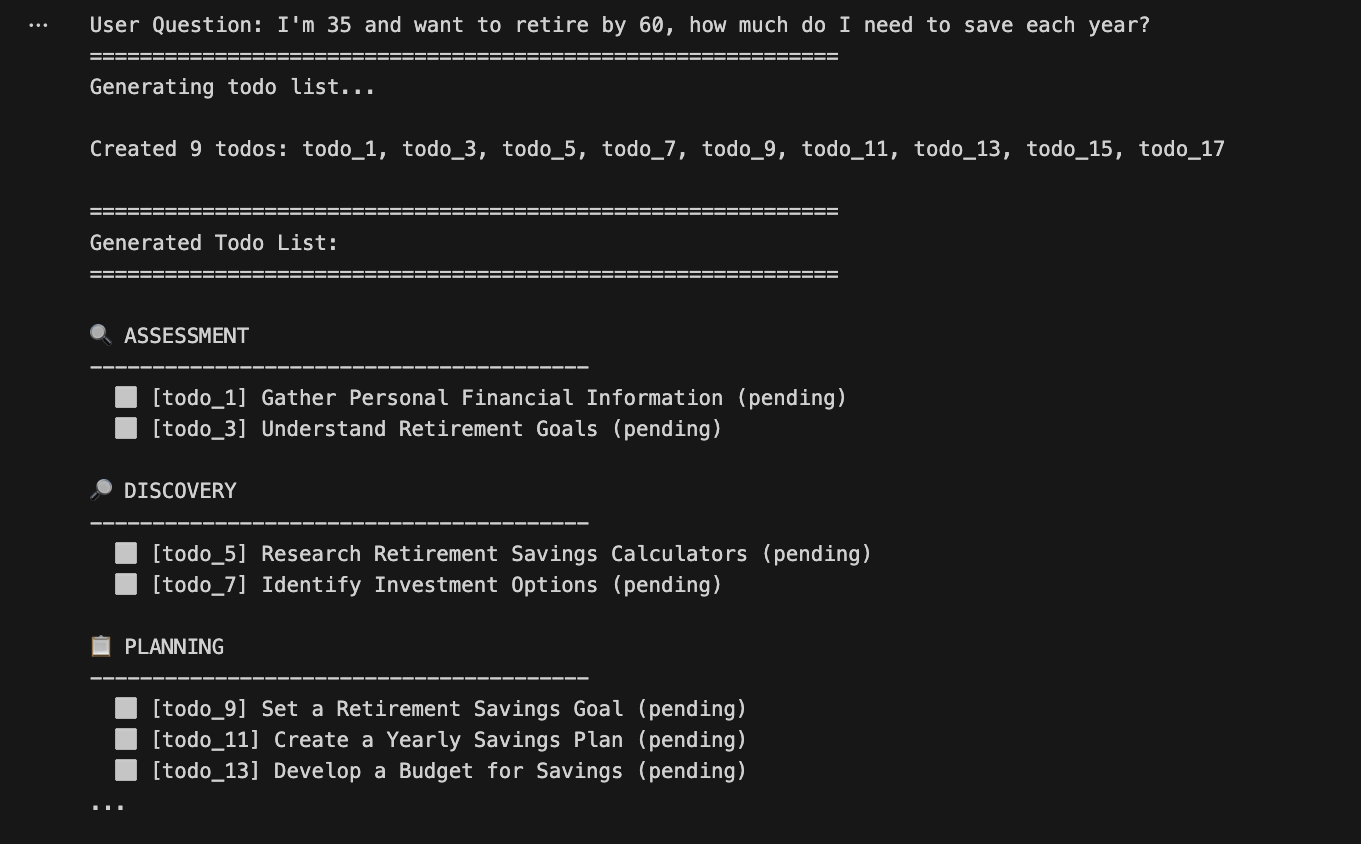

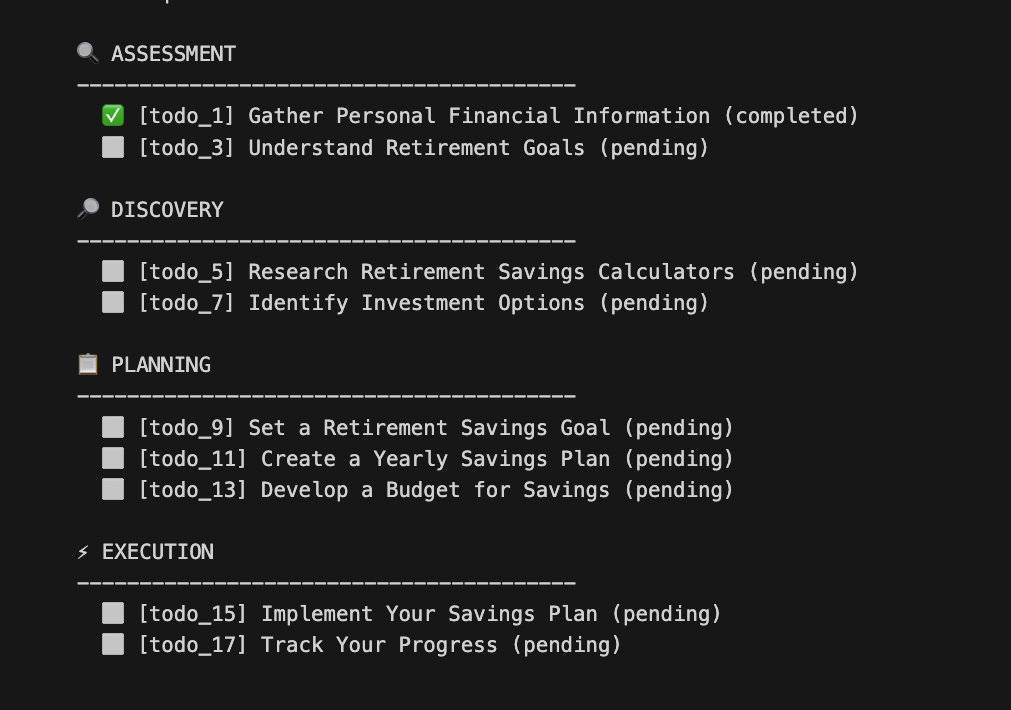

In [37]:
from IPython.display import Image, display
display(Image("generated-plans.png"))
display(Image("progress-tracking.png"))

In [ ]:
# Test the complete system with short-term memory
TODO_STORE.clear()

# Generate new thread_id for this conversation session
session_thread_id = uuid.uuid4()
session_config = {"configurable": {"thread_id": session_thread_id}}

print(f"🧠 Short-Term Memory Session:")
print(f"   thread_id: {session_thread_id}")
print(f"   user_id: {user_id}")
print("-" * 50)

# User message for this conversation
user_message = """Hi! My user_id is user_alex. I asked for you to create a 90 Day Action Plan to be a better person.  
Can your review the created files and make two more finance goals, I'd like to buy a car for 3k in 90 days.
Can you also make the exercise goal more specific, I'd like to lose 10lbs in 90 days.
"""

# Store user message in short-term memory (indexed by thread_id)
short_term_store.put(
    namespace=(str(session_thread_id), "messages"),
    key="user_input",
    value={"role": "user", "content": user_message, "timestamp": datetime.now().isoformat()}
)

result = life_coach.invoke({
    "messages": [{"role": "user", "content": user_message}]
}, config=session_config)

# Store assistant response in short-term memory
assistant_response = result["messages"][-1].content
short_term_store.put(
    namespace=(str(session_thread_id), "messages"),
    key="assistant_response",
    value={"role": "assistant", "content": assistant_response, "timestamp": datetime.now().isoformat()}
)

print("\n" + "=" * 50)
print("Life Coach response:")
print("=" * 50)
print(assistant_response)

# Show what's in short-term memory for this session
print("\n" + "=" * 50)
print("📝 Short-Term Memory Contents:")
print("=" * 50)
session_messages = list(short_term_store.search((str(session_thread_id), "messages")))
for msg in session_messages:
    print(f"  [{msg.key}]: {msg.value['role']} @ {msg.value['timestamp'][:19]}")

Life Coach response:
Perfect! I've completed your 90 Day Action Plan with your requested updates. Here's what I've created and updated:

## 📋 **Plan Review & Updates Completed**

### 🆕 **New Comprehensive 90 Day Action Plan**
I've created a detailed `/user_alex/plans/90_day_action_plan.md` that integrates all aspects of becoming a better person:

**Key Features:**
- **Structured 90-day timeline** with monthly phases
- **Weekly milestones** and daily habits
- **Family-integrated activities** considering your dependent
- **Realistic scheduling** for your full-time software engineer role

### 💰 **Updated Finance Goals (As Requested)**
1. **Car Purchase Goal:** Save $3,000 in 90 days
   - Month 1: $500 + Month 2: $500 + Month 3: $1,000
   - Integrated with your existing emergency fund goal
   - Specific strategies for SF cost of living

2. **Emergency Fund Completion:** Add $1,800 over 90 days
   - $600/month to complete your 6-month fund
   - Currently at 40% → Target: 100% completion

##

INPUT:
result = life_coach.invoke({
    "messages": [{
        "role": "user",
        "content": """Hi! My user_id is user_alex. I'd like you to create a 90 Day Action Plan to be a better person.

I want to focus on:
1. Building a consistent exercise routine (I can exercise 3x per week for 30 mins)
2. Improve my finances and save money
3. Improve my relationships and social connections
4. Work towards a promotion at work

Please create comprehensive plans for each area and save them as separate files I can reference."""
    }]
})

OUTPUT:
Life Coach response:
Perfect! I've completed your comprehensive 90-day action plan to become a better person. Here's what I've created for you:

## 🎉 Your Complete 90-Day Transformation Package

I've created **5 detailed files** that you can reference throughout your journey:

### 📋 Master Plan
**`/alex_master_90day_action_plan.md`** - Your complete integrated 90-day roadmap with:
- Daily and weekly schedules combining all four focus areas
- Progress tracking templates
- Milestone celebrations and rewards system  
- Anxiety management strategies throughout
- Technology tools and apps to support success

### 📚 Individual Domain Plans

1. **`/alex_fitness_plan_90days.md`** - Complete exercise program featuring:
   - Progressive 12-week workout plan (3x/week, 30+ mins)
   - Anxiety-friendly exercises with mindfulness integration
   - Week-by-week progression from gentle yoga to circuit training
   - Morning routine optimization for energy and sleep improvement

2. **`/alex_financial_plan_90days.md`** - Comprehensive money management system:
   - Goal to save $1,200 over 90 days
   - Build $500 emergency fund
   - Practical money-saving strategies and budgeting system
   - Weekly and monthly financial tracking templates

3. **`/alex_relationships_plan_90days.md`** - Social connection expansion plan:
   - Anxiety-friendly approach to meeting new people
   - Strategies for deepening existing relationships  
   - Progressive challenges from comfort zone to hosting events
   - Online and offline relationship building techniques

4. **`/alex_career_plan_90days.md`** - Strategic promotion preparation:
   - Skills assessment and development plan
   - Professional networking and mentorship strategies
   - Leadership development opportunities
   - Performance improvement and visibility tactics

## 🌟 Key Features Tailored for You

✅ **Anxiety-Friendly**: Every plan considers your mild anxiety with gentle progressions and coping strategies  
✅ **Vegetarian-Optimized**: Fitness and financial plans account for your dietary preferences  
✅ **Morning-Focused**: Exercise routines designed for your preferred morning schedule  
✅ **Detailed Communication**: Comprehensive plans matching your communication style preference  
✅ **Energy & Sleep Goals**: All plans support your primary goals of better energy and sleep

## 🚀 Your Next Steps

1. **Review the Master Plan** to understand how everything integrates
2. **Set your official start date** and mark it in the master plan
3. **Set up tracking systems** (apps, calendar reminders, journal)
4. **Read through each domain-specific plan** to familiarize yourself with the details
5. **Begin Week 1** with confidence knowing you have a comprehensive roadmap

## 📈 Expected Outcomes After 90 Days

- **Fitness**: Established exercise habit with increased energy and better sleep
- **Finance**: $1,200+ saved with sustainable budgeting habits  
- **Relationships**: Expanded social network with deeper, more meaningful connections
- **Career**: Clear path toward promotion with enhanced skills and professional visibility

All plans are designed to work together synergistically - your morning exercise routine supports energy for career activities, your financial discipline creates confidence for social activities, and your relationship building supports professional networking.

You have everything you need to transform into the better person you want to become. The journey starts with your first morning workout and your first tracked expense. You've got this! 💪✨



TODO_STORE.clear()

result = life_coach.invoke({
    "messages": [{
        "role": "user",
        "content": """Hi! My user_id is user_alex. I asked for you to create a 90 Day Action Plan to be a better person.  
        Can your review the created files and make two more finance goals, I'd like to buy a car for 3k in 90 days.
        Can you also make the exercise goal more specific, I'd like to lose 10lbs in 90 days.
        """
    }]
})

Life Coach response:
Perfect! I've completed your 90 Day Action Plan with your requested updates. Here's what I've created and updated:

## 📋 **Plan Review & Updates Completed**

### 🆕 **New Comprehensive 90 Day Action Plan**
I've created a detailed `/user_alex/plans/90_day_action_plan.md` that integrates all aspects of becoming a better person:

**Key Features:**
- **Structured 90-day timeline** with monthly phases
- **Weekly milestones** and daily habits
- **Family-integrated activities** considering your dependent
- **Realistic scheduling** for your full-time software engineer role

### 💰 **Updated Finance Goals (As Requested)**
1. **Car Purchase Goal:** Save $3,000 in 90 days
   - Month 1: $500 + Month 2: $500 + Month 3: $1,000
   - Integrated with your existing emergency fund goal
   - Specific strategies for SF cost of living

2. **Emergency Fund Completion:** Add $1,800 over 90 days
   - $600/month to complete your 6-month fund
   - Currently at 40% → Target: 100% completion

### 🏃‍♂️ **Specific Exercise Goal (As Requested)**
**Goal:** Lose 10 pounds in 90 days through structured routine
- **Phase 1 (Month 1):** 3x/week foundation building
- **Phase 2 (Month 2):** 4x/week intensity building  
- **Phase 3 (Month 3):** 5x/week peak performance
- **Family-friendly:** Saturday activities include your dependent
- **Realistic:** Morning/evening options for your work schedule

### 🎯 **Integration with Existing Plans**
- **Maintained** your successful energy improvement plan (6:30 AM wake, sleep hygiene)
- **Built upon** your current 7/10 energy level goal
- **Aligned** with your values: health, family, financial security
- **Respected** your moderate coaching preference and detailed communication style

### 📊 **Updated Goal Files**
- **Short-term goals** now include specific 10lb weight loss and $3k car purchase
- **Medium-term goals** updated to reflect fitness routine evolution
- **All goals** have detailed tracking metrics and timelines

## 🎉 **Your Next Steps**
1. **Week 1 Actions:** Set up budget tracking, schedule first 3 workouts, take baseline measurements
2. **Car Research:** Start looking at vehicles in your $3k range
3. **Family Discussion:** Share the plan with your spouse for support
4. **Track Progress:** Weekly weigh-ins and financial check-ins

The plan is designed to work with your busy life as a software engineer and family person, while being ambitious enough to create real transformation. You've got this! 💪

Would you like me to explain any part of the plan in more detail or help you get started with the first week's action items?

In [34]:
# Review what was created
# TODO: DJY - review life coach test
print("=" * 60)
print("FINAL TODO STATUS")
print("=" * 60)
print(list_todos.invoke({}))

print("\n" + "=" * 60)
print("GENERATED FILES")
print("=" * 60)
for f in sorted(WORKSPACE.iterdir()):
    if f.is_file():
        print(f"  [FILE] {f.name} ({f.stat().st_size} bytes)")
    elif f.is_dir():
        print(f"  [DIR] {f.name}/")

FINAL TODO STATUS

🔍 ASSESSMENT
----------------------------------------
  ✅ [todo_1] Review current goals and create 90-day action plan structure (completed)

📋 PLANNING
----------------------------------------
  ✅ [todo_3] Design finance goals including $3k car purchase (completed)
  ✅ [todo_5] Create specific 10lb weight loss exercise plan (completed)
  ✅ [todo_7] Integrate wellness, finance, career, and relationship goals (completed)

⚡ EXECUTION
----------------------------------------
  🔄 [todo_9] Create comprehensive 90 Day Action Plan document (in_progress)
  ✅ [todo_11] Update goal files with new specific targets (completed)

GENERATED FILES
  [FILE] 90_day_financial_plan.txt (2700 bytes)
  [FILE] alex_career_plan_90days.md (13805 bytes)
  [FILE] alex_financial_plan_90days.md (5674 bytes)
  [FILE] alex_fitness_plan_90days.md (3946 bytes)
  [FILE] alex_master_90day_action_plan.md (10220 bytes)
  [FILE] alex_relationships_plan_90days.md (9146 bytes)
  [DIR] coaching/
  [DIR] use

In [35]:
# Read one of the generated files
# TODO: DJY - test single generated file
files = list(WORKSPACE.glob("*.md"))
if files:
    print(f"\nContents of {files[0].name}:")
    print("=" * 60)
    print(files[0].read_text()[:2000] + "..." if len(files[0].read_text()) > 2000 else files[0].read_text())


Contents of alex_master_90day_action_plan.md:
# Alex's Master 90-Day Action Plan: Become a Better Person

**Start Date**: [Insert your start date]  
**User Profile**: Vegetarian, mild anxiety, morning exercise preference, detailed communication style  
**Mission**: Transform across four key life areas through consistent, sustainable actions

## 🎯 Four Pillars of Transformation

1. **💪 Fitness & Health**: Build consistent 3x/week exercise routine
2. **💰 Financial Wellness**: Improve finances and save $1,200 
3. **🤝 Relationships**: Expand social connections and deepen relationships
4. **📈 Career Growth**: Position for promotion through strategic development

## 📅 90-Day Integration Calendar

### Month 1: Foundation Building (Days 1-30)

#### Week 1: Assessment & Setup
**Fitness**: Start gentle yoga, walking, bodyweight exercises  
**Finance**: Set savings goals, create budget, track expenses  
**Relationships**: Self-reflection, set relationship goals, prepare conversation tools  
**Ca

---
## Summary

In this session, we explored **Deep Agents** and their four key elements:

| Element | Purpose | Implementation |
|---------|---------|----------------|
| **Planning** | Track complex tasks | `write_todos`, `update_todo`, `list_todos` |
| **Context Management** | Handle large contexts | File system tools, automatic offloading |
| **Subagent Spawning** | Delegate to specialists | `task` tool with custom configs |
| **Long-term Memory** | Remember across sessions | LangGraph Store integration |

### Key Takeaways:

1. **Deep Agents handle complexity** - Unlike simple tool loops, they can manage long-horizon, multi-step tasks
2. **Planning is context engineering** - Todo lists and files aren't just organization—they're extended memory
3. **Subagents prevent context bloat** - Delegation keeps the main agent focused and efficient
4. **Skills enable progressive disclosure** - Load capabilities on-demand instead of upfront
5. **The CLI makes interaction natural** - Interactive sessions with conversation resume

### Deep Agents vs Traditional Agents

| Aspect | Traditional Agent | Deep Agent |
|--------|-------------------|------------|
| Task complexity | Simple, single-step | Complex, multi-step |
| Context management | All in conversation | Files + summaries |
| Delegation | None | Subagent spawning |
| Memory | Within thread | Across sessions |
| Planning | Implicit | Explicit (todos) |

### When to Use Deep Agents

**Use Deep Agents when:**
- Tasks require multiple steps or phases
- Context would overflow in a simple loop
- Specialization would improve quality
- Users need to resume sessions
- Long-term memory is valuable

**Use Simple Agents when:**
- Tasks are straightforward Q&A
- Single tool call suffices
- Context fits easily
- No need for persistence

### Further Reading

- [Deep Agents Documentation](https://docs.langchain.com/oss/python/deepagents/overview)
- [Deep Agents GitHub](https://github.com/langchain-ai/deepagents)
- [Context Management Blog Post](https://www.blog.langchain.com/context-management-for-deepagents/)
- [Building Multi-Agent Applications](https://www.blog.langchain.com/building-multi-agent-applications-with-deep-agents/)
- [LangGraph Memory Concepts](https://langchain-ai.github.io/langgraph/concepts/memory/)